##### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn imports for data processing and model building
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.utils.fixes import loguniform
from scipy.stats import randint

# TensorFlow/Keras imports for LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the datasets

In [2]:
weather_data = pd.read_excel(r"weather_features.xlsx")
energy_data = pd.read_excel(r"energy_dataset.xlsx")

#### Inspect datasets 

In [3]:
# Display shape and head
print("Weather Data Shape:", weather_data.shape)
print("Weather Data Head:\n", weather_data.head())

Weather Data Shape: (178396, 17)
Weather Data Head:
                       dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   

In [4]:
# Display shape and head
print("\nEnergy Data Shape:", energy_data.shape)
print("Energy Data Head:\n", energy_data.head())


Energy Data Shape: (35064, 29)
Energy Data Head:
                         time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1

#### Prepare weather data (EDA: Exploratary Data Analysis)

In [5]:
#drop the 'city_name' column.
weather_data = weather_data.drop(columns=['city_name'])

##### Aggregate weather data 

In [6]:
# Ensure categorical columns are strings
weather_data['weather_main'] = weather_data['weather_main'].astype(str)
weather_data['weather_description'] = weather_data['weather_description'].astype(str)
weather_data['weather_icon'] = weather_data['weather_icon'].astype(str)


In [7]:
# Define a function to get the most frequent value
def most_frequent(series):
    if series.mode().empty:
        return None
    return series.mode().astype(str)[0]


In [8]:
# Group by 'dt_iso' and aggregate the data
aggregated_data = weather_data.groupby('dt_iso').agg(
    {
        'temp': 'mean',
        'temp_min': 'mean',
        'temp_max': 'mean',
        'pressure': 'mean',
        'humidity': 'mean',
        'wind_speed': 'mean',
        'wind_deg': 'mean',
        'rain_1h': 'mean',
        'rain_3h': 'mean',
        'snow_3h': 'mean',
        'clouds_all': 'mean',
        'weather_id': 'mean',
        'weather_main': most_frequent,
        'weather_description': most_frequent,
        'weather_icon': most_frequent
    }
).reset_index()


In [9]:
print(aggregated_data.head(5))

                      dt_iso        temp    temp_min    temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  272.491463  272.491463  272.491463    1016.4   
1  2015-01-01 01:00:00+01:00  272.512700  272.512700  272.512700    1016.2   
2  2015-01-01 02:00:00+01:00  272.099137  272.099137  272.099137    1016.8   
3  2015-01-01 03:00:00+01:00  272.089469  272.089469  272.089469    1016.6   
4  2015-01-01 04:00:00+01:00  272.145900  272.145900  272.145900    1016.6   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0      82.4         2.0     135.2      0.0      0.0      0.0         0.0   
1      82.4         2.0     135.8      0.0      0.0      0.0         0.0   
2      82.0         2.4     119.0      0.0      0.0      0.0         0.0   
3      82.0         2.4     119.2      0.0      0.0      0.0         0.0   
4      82.0         2.4     118.4      0.0      0.0      0.0         0.0   

   weather_id weather_main weather_description weather_icon  
0       800.

In [10]:
aggregated_data.shape

(35064, 16)

# Merging Datasets.

In [11]:
weather_aggregated_data = aggregated_data

###### Merge datasets as a Left Join based on 'time' columns 

In [12]:
merged_data = pd.merge(energy_data, weather_aggregated_data, left_on= 'time' , right_on= 'dt_iso')

In [13]:
# Display shape and head of the merged data
print("\nMerged Data Shape:", merged_data.shape)
print("Merged Data Head:\n", merged_data.head())


Merged Data Shape: (35064, 45)
Merged Data Head:
                         time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1

In [14]:
#drop the 'dt_iso' column from the merge_data
merged_data = merged_data.drop(columns=['dt_iso']) 

In [15]:
# converting datetime column back to the string
merged_data['time'] = merged_data['time'].astype(str)

In [16]:
# Null value count in the merged data
print("\nMissing Values Count in Merged Data:")
print(merged_data.isnull().sum())


Missing Values Count in Merged Data:
time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generati

In [17]:
#droping the columns which having the sum zero or null values
merged_data = merged_data.drop(columns=['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation hydro pumped storage aggregated','generation marine','generation wind offshore','forecast wind offshore eday ahead']) 

In [18]:
merged_data.shape

(35064, 36)

In [19]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

##### Imputes the Values 

In [20]:
# Handle missing values using different techniques
merged_data = merged_data.ffill().bfill()  # Forward fill, then backward fill


In [21]:
# To ensure whether the missing values are filled or not.
print("\nMissing Values Count in Merged Data:")
print(merged_data.isnull().sum())


Missing Values Count in Merged Data:
time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                

In [22]:
merged_data.shape

(35064, 36)

In [23]:
# Statistical summary
print("\nMerged Data Statistical Summary:")
print(merged_data.describe())


Merged Data Statistical Summary:
       generation biomass  generation fossil brown coal/lignite  \
count        35064.000000                          35064.000000   
mean           383.532797                            448.091918   
std             85.346455                            354.616732   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count           35064.000000                 35064.000000   
mean             5622.705653                  4256.550622   
std              2201.557635                  1961.973297   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000

In [24]:
# converting datetime column back to the string
merged_data['time'] = merged_data['time'].astype(str)

In [25]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35064 non-null  float64
 2   generation fossil brown coal/lignite         35064 non-null  float64
 3   generation fossil gas                        35064 non-null  float64
 4   generation fossil hard coal                  35064 non-null  float64
 5   generation fossil oil                        35064 non-null  float64
 6   generation hydro pumped storage consumption  35064 non-null  float64
 7   generation hydro run-of-river and poundage   35064 non-null  float64
 8   generation hydro water reservoir             35064 non-null  float64
 9   generation nuclear                           35064 non-null  float64
 10

In [26]:
#Save the merged dataset
output_file_path = r"C:\Users\deepk\Desktop\SpringBoard\merged_data.xlsx"
merged_data.to_excel(output_file_path, index=False)

# Feature Engineering


##### Outliers detection and remove

In [27]:
# Detecting and visualizing outliers using boxplot and IQR (Interquartile Range ) method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [28]:
# Define columns to check for outliers
columns_to_check = ['price actual', 'total load actual', 'temp', 'humidity', 'wind_speed']


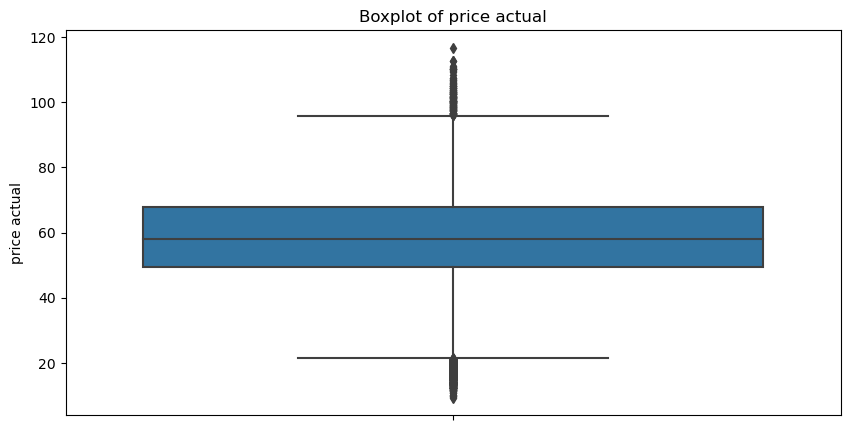


Number of Outliers in price actual: 699


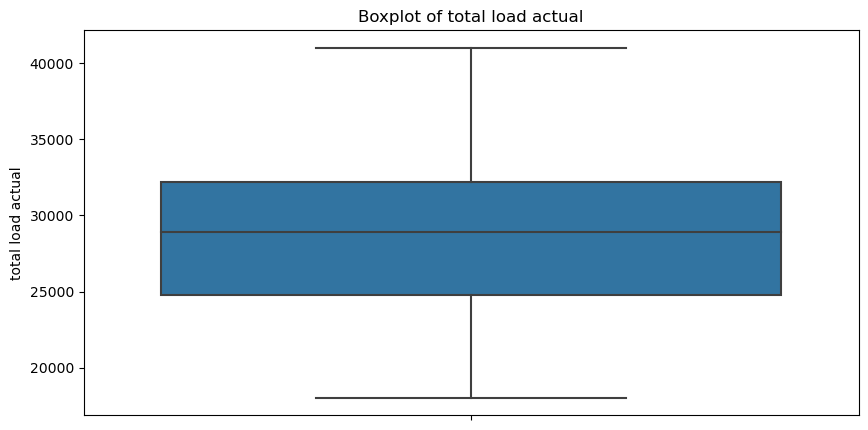


Number of Outliers in total load actual: 0


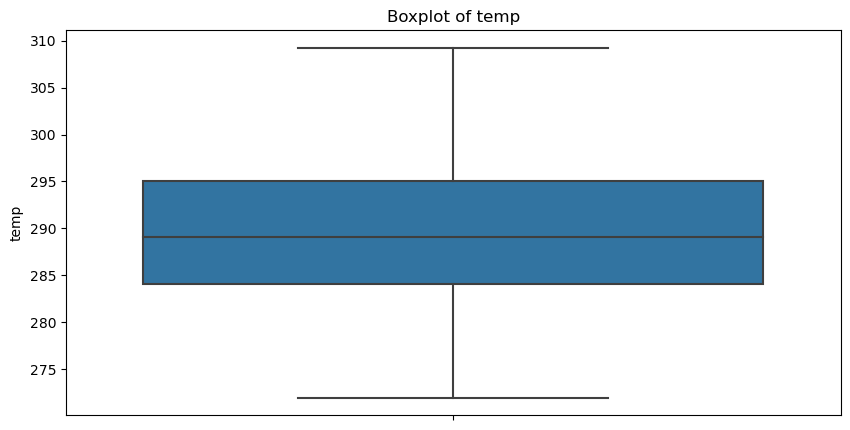


Number of Outliers in temp: 0


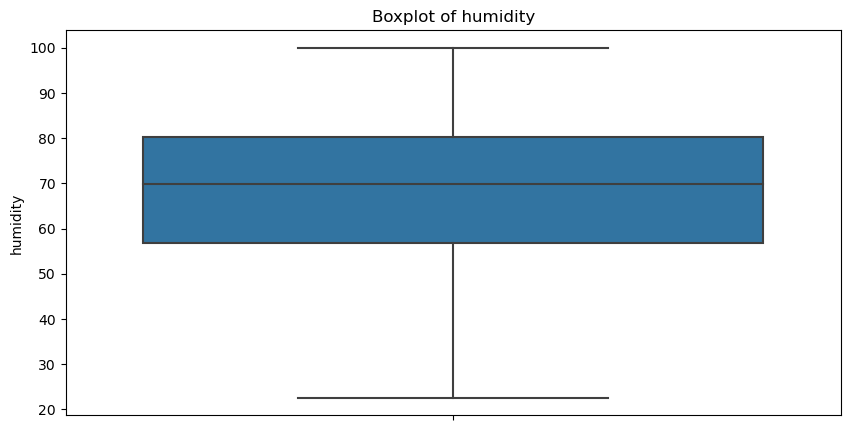


Number of Outliers in humidity: 0


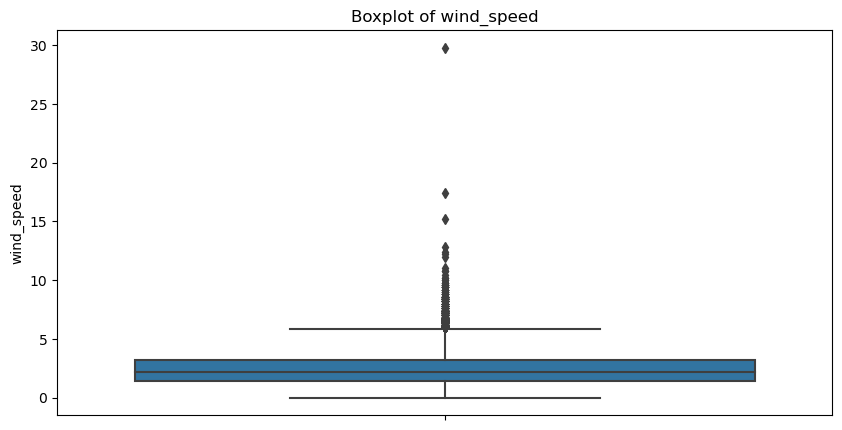


Number of Outliers in wind_speed: 830


In [29]:
# Plot boxplots and detect outliers for each column
for column in columns_to_check:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=merged_data, y=column)
    plt.title(f'Boxplot of {column}')
    plt.show()
    
    outliers = detect_outliers_iqr(merged_data, column)
    print(f"\nNumber of Outliers in {column}: {outliers.shape[0]}")

In [30]:
Q1 = merged_data['price actual'].quantile(0.25)
Q3 = merged_data['price actual'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [31]:
#replace outliers with NaN
merged_data['price actual interpolation'] = merged_data['price actual'].apply(
lambda x: None if x < lower_bound or x > upper_bound else x)
merged_data['price actual interpolation'].isnull().sum()

699

In [32]:
#Interpolate to replace the NaN values
merged_data['price actual interpolation'] = merged_data['price actual interpolation'].interpolate()
merged_data['price actual interpolation'].isnull().sum()

0

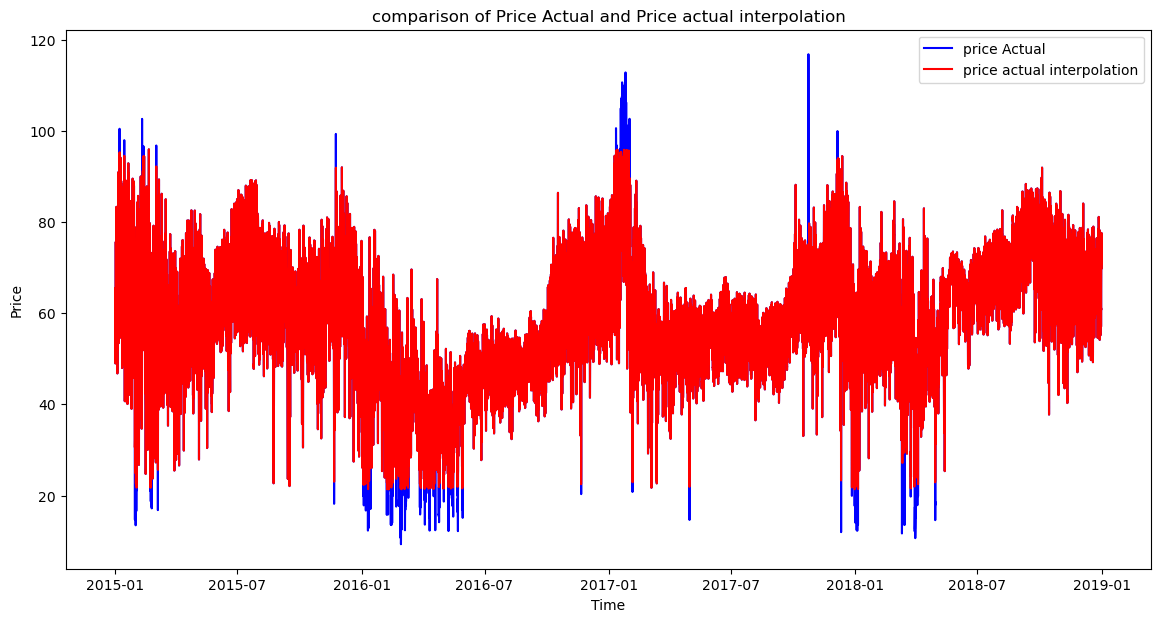

In [50]:
#Compare after removing the outliers
plt.figure(figsize=(14,7))

#ploting the price actual value
plt.plot(merged_data['time'],merged_data['price actual'], label='price Actual', color='blue', linestyle='-')

#plot the 'price actual interpolation' values
plt.plot(merged_data['time'],merged_data['price actual interpolation'], label='price actual interpolation', color='red', linestyle='-')

plt.title('comparison of Price Actual and Price actual interpolation')
plt.xlabel('Time')
plt.ylabel('Price')

plt.legend()

plt.show()

In [33]:
#ensure 'time' column is in datetime format
merged_data['time'] = pd.to_datetime(merged_data['time'], utc=True).dt.tz_convert(None)

##### Creating some new columns

Creating is_weekday column

In [34]:
#Extract the day of the week from the 'time' column 
# Monday=0, Sunday=0
merged_data['day_of_week'] = merged_data['time'].dt.dayofweek

#new column for indicating whether 
merged_data['is_weekday'] = merged_data['day_of_week'].apply(lambda x: '0' if x >= 5 else '1')

Creating peak/off Peak column


In [35]:
merged_data['hour'] = merged_data['time'].dt.hour

#calculate the average electricity demand for each hour across all days 
hourly_avg_demand = merged_data.groupby('hour')['total load actual'].mean().reset_index()
hourly_avg_demand.columns = ['hour' , 'hourly_avg_demand']

merged_data = pd.merge(merged_data , hourly_avg_demand, on='hour', how='left')

#Creating peak/off Peak column
merged_data['peak|off-peak'] =merged_data.apply(lambda row: 1 if row ['total load actual'] > row['hourly_avg_demand'] else 0, axis=1)

Creating the Column for each month

In [36]:
## Ensure the 'time' column is in datetime format
merged_data['time'] = pd.to_datetime(merged_data['time'], utc=True).dt.tz_convert(None)

# Create new columns for each month
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
          'August', 'September', 'October', 'November', 'December']

for month_index, month in enumerate(months, start=1):
    merged_data[month] = (merged_data['time'].dt.month == month_index).astype(int)

In [37]:
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,March,April,May,June,July,August,September,October,November,December
0,2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0,0,0,0,0,0,0,0,0,0
3,2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#coverting the datetime to hr months and days
merged_data['time'] = pd.to_datetime(merged_data['time'], format='%Y/%m/%d %H:%M:%S',errors='coerce')
#dividing the time to month day weekday weekend
merged_data['month'] = merged_data['time'].dt.month
merged_data['day'] = merged_data['time'].dt.day
merged_data['weekday'] = merged_data['time'].dt.day_name()
merged_data['weekend'] = merged_data['time'].dt.weekday >= 5
merged_data.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,July,August,September,October,November,December,month,day,weekday,weekend
0,2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0,0,0,0,0,1,12,31,Wednesday,False
1,2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0,0,0,0,0,0,1,1,Thursday,False
2,2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0,0,0,0,0,0,1,1,Thursday,False
3,2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0,0,0,0,0,0,1,1,Thursday,False
4,2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0,0,0,0,0,0,1,1,Thursday,False


# Visualization

##### Correlation Matrix

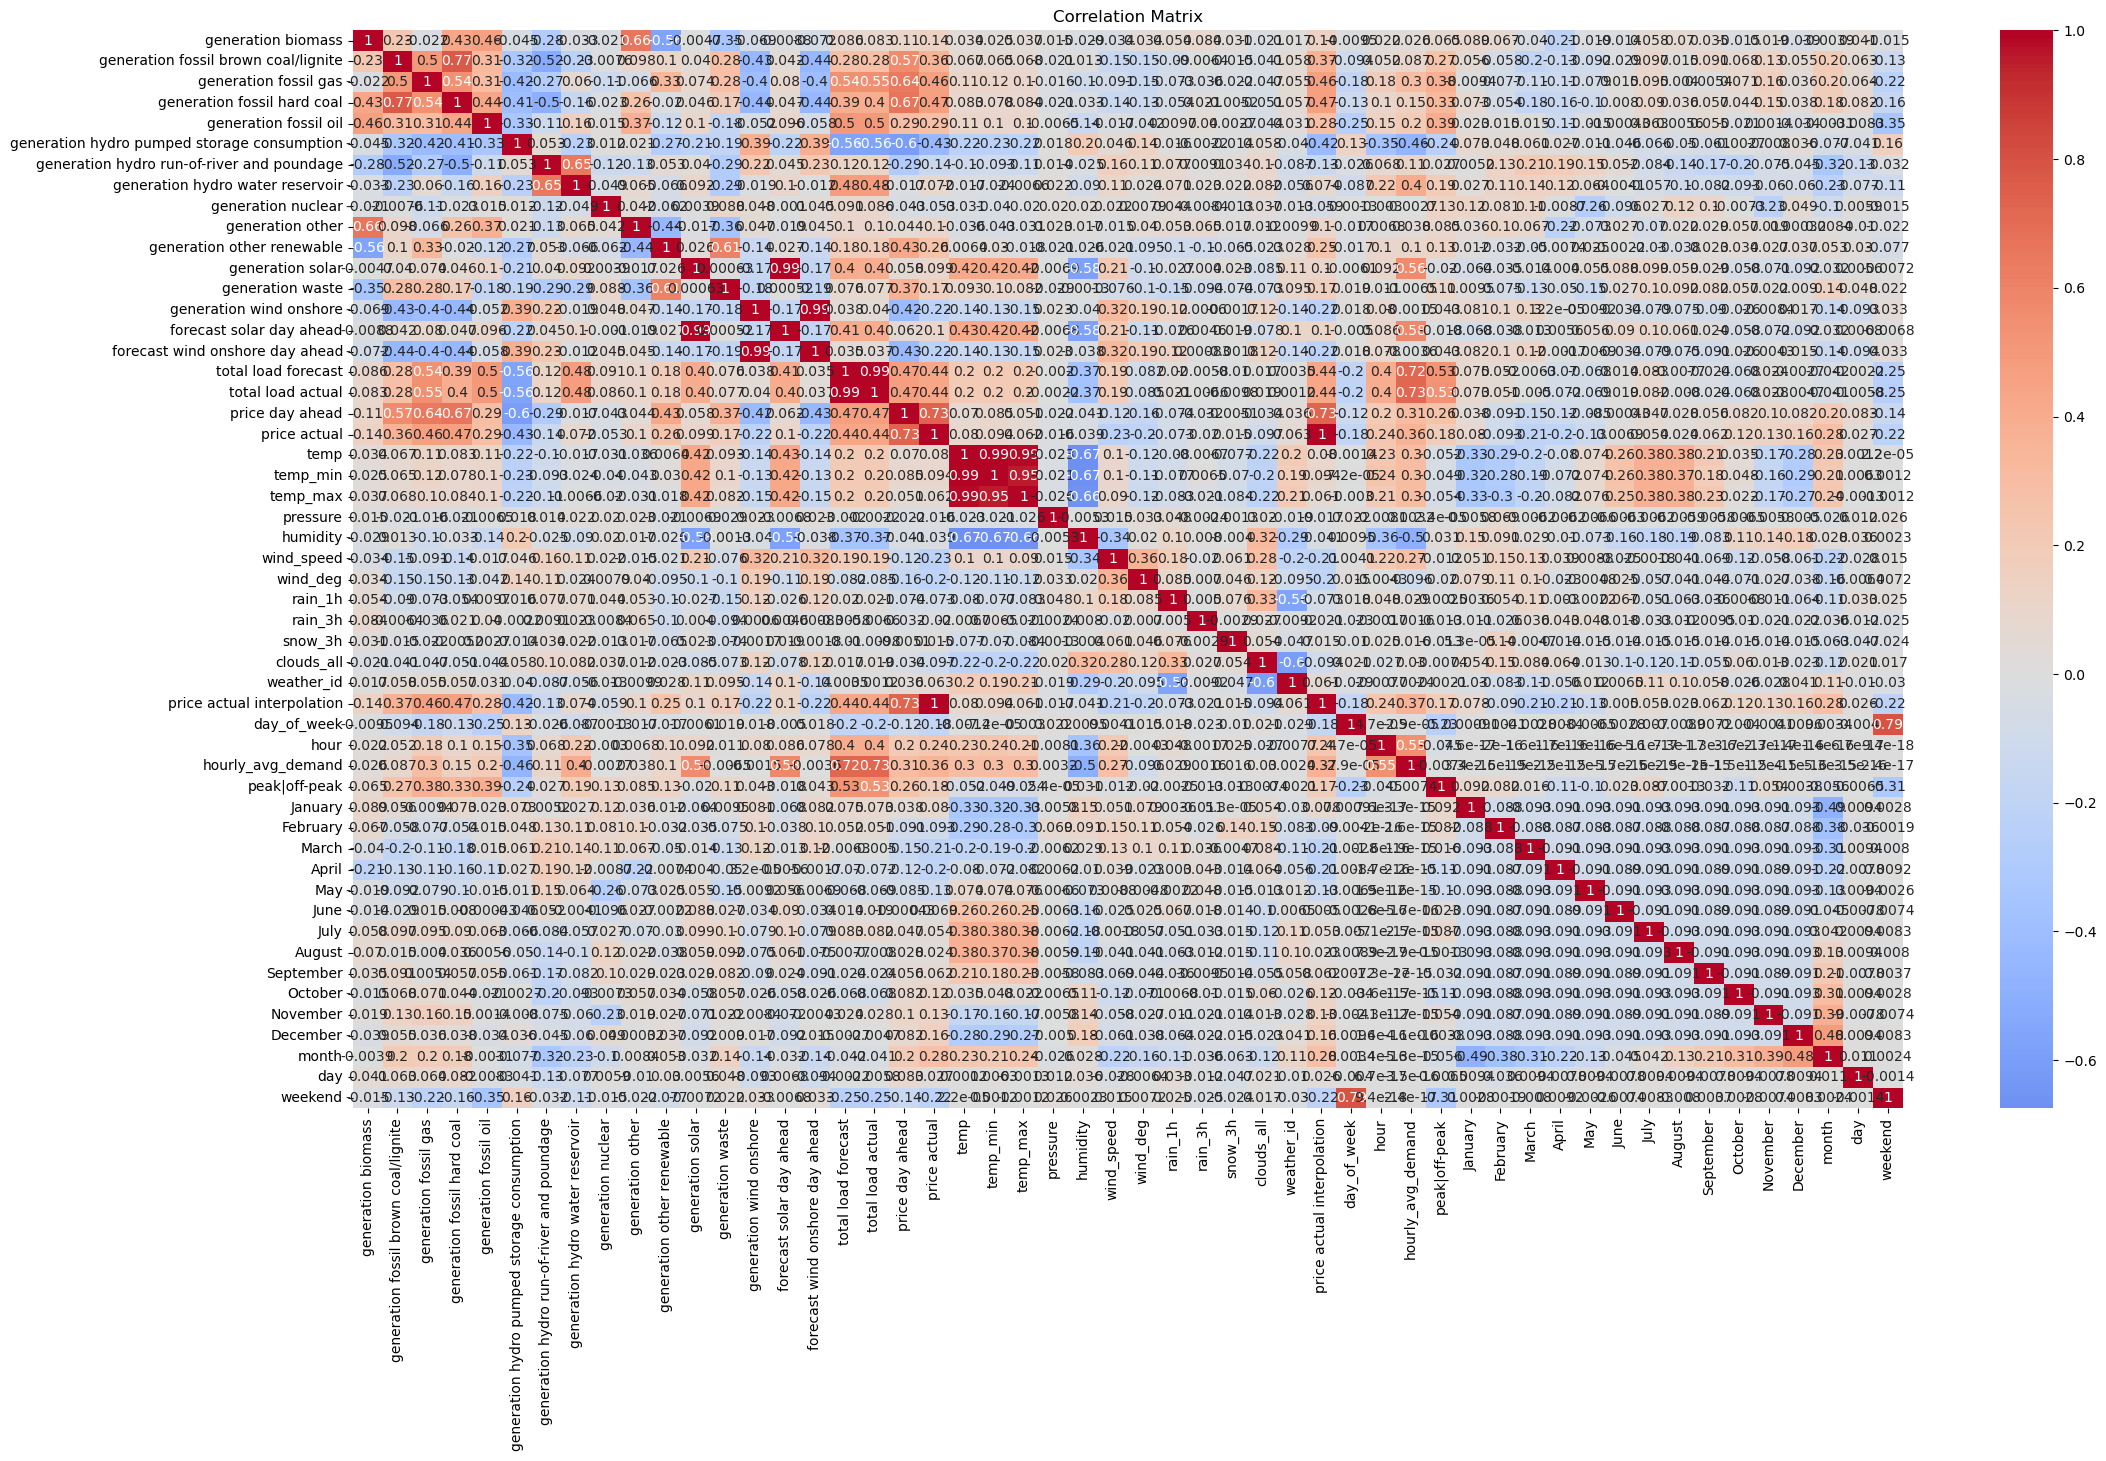

In [39]:
# Correlation Analysis
plt.figure(figsize=(25, 14))
correlation_matrix = merged_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

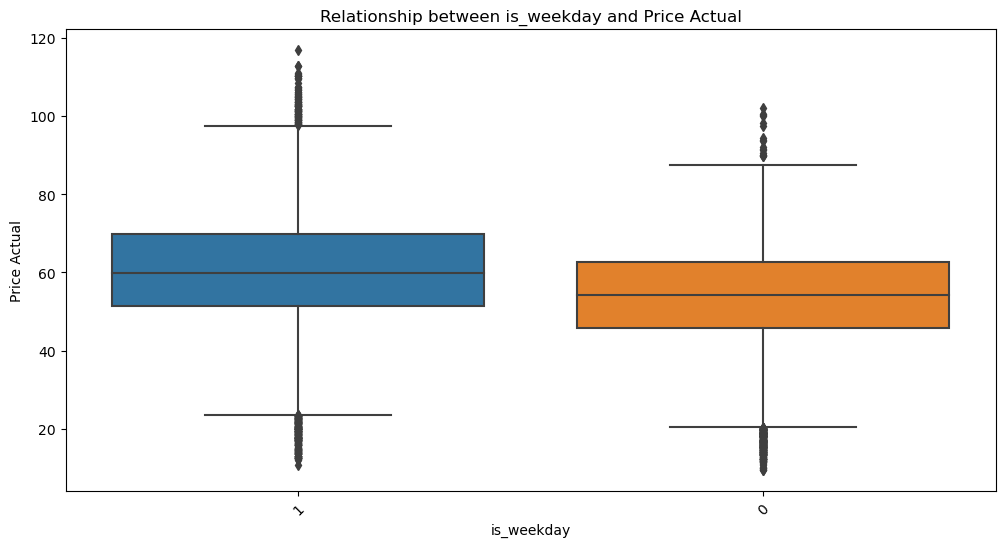

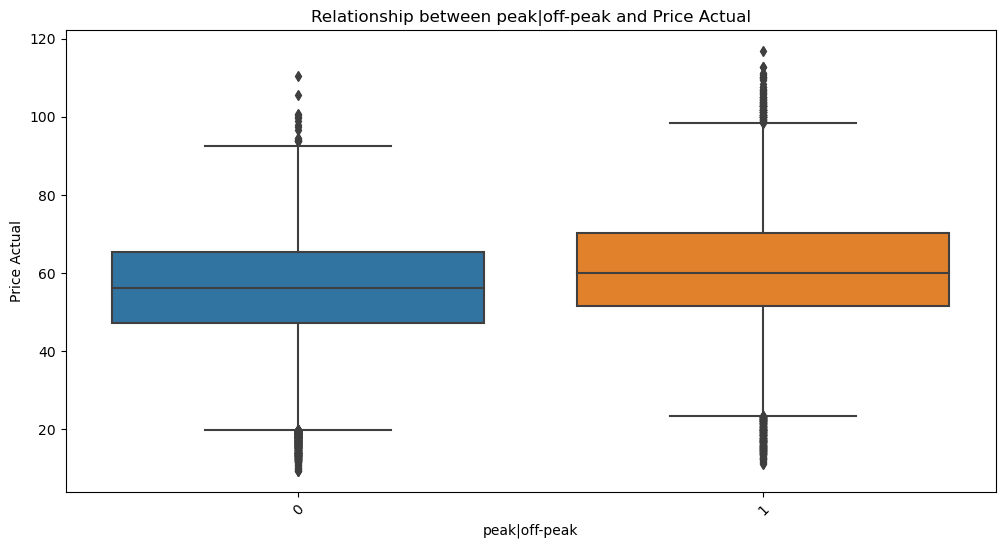

In [40]:
# Box plots for categorical features
categorical_features = ['is_weekday', 'peak|off-peak']
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=merged_data, x=feature, y='price actual')
    plt.title(f'Relationship between {feature} and Price Actual')
    plt.xlabel(feature)
    plt.ylabel('Price Actual')
    plt.xticks(rotation=45)
    plt.show()


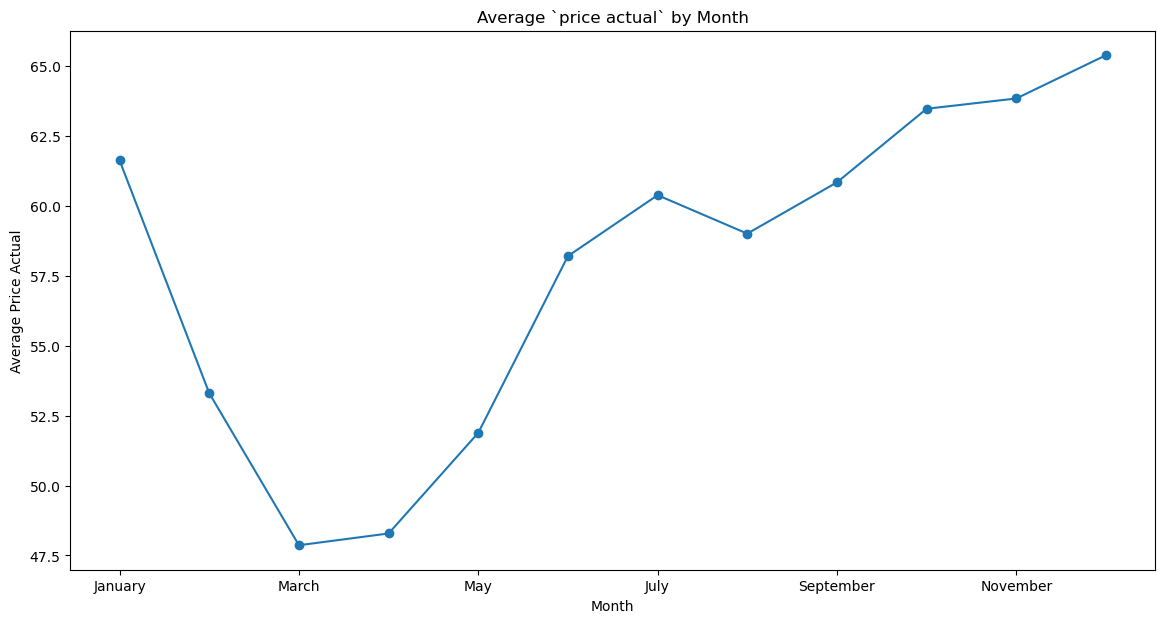

In [41]:
# Extract month and calculate average price actual for each month
monthly_avg_price = merged_data.groupby(merged_data['time'].dt.month_name())['price actual'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 
    'August', 'September', 'October', 'November', 'December'])

# Set plot size
plt.figure(figsize=(14, 7))

# Create a line plot
monthly_avg_price.plot(kind='line', marker='o')

# Add titles and labels
plt.title('Average `price actual` by Month')
plt.xlabel('Month')
plt.ylabel('Average Price Actual')

# Display the plot
plt.show()

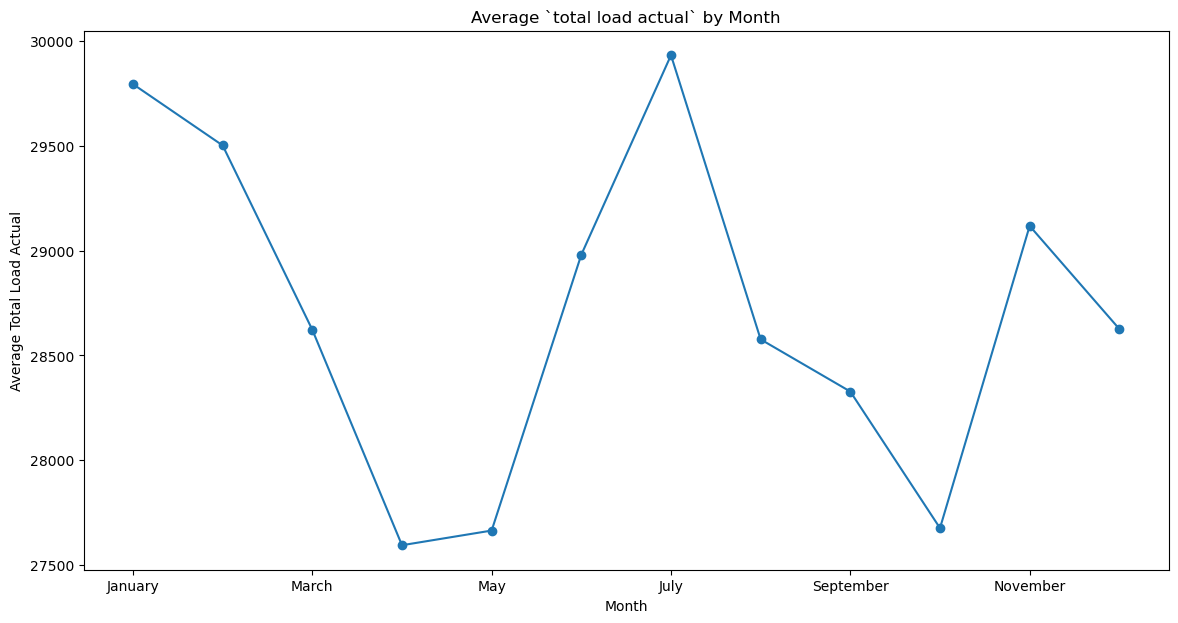

In [42]:
# Extract month and calculate average total load actual for each month
monthly_avg_load = merged_data.groupby(merged_data['time'].dt.month_name())['total load actual'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 
    'August', 'September', 'October', 'November', 'December'])

# Set plot size
plt.figure(figsize=(14, 7))

# Create a line plot
monthly_avg_load.plot(kind='line', marker='o')

# Add titles and labels
plt.title('Average `total load actual` by Month')
plt.xlabel('Month')
plt.ylabel('Average Total Load Actual')

# Display the plot
plt.show()


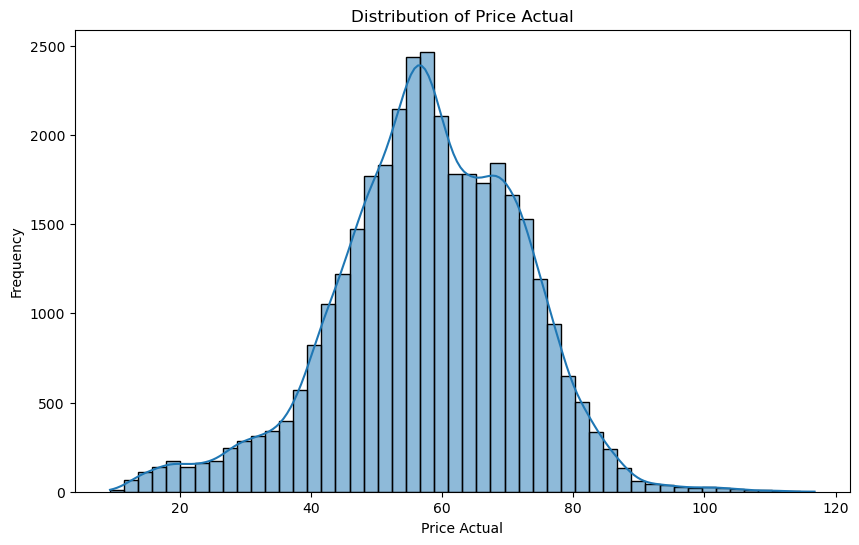

In [43]:
# Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['price actual'], bins=50, kde=True)
plt.title('Distribution of Price Actual')
plt.xlabel('Price Actual')
plt.ylabel('Frequency')
plt.show()


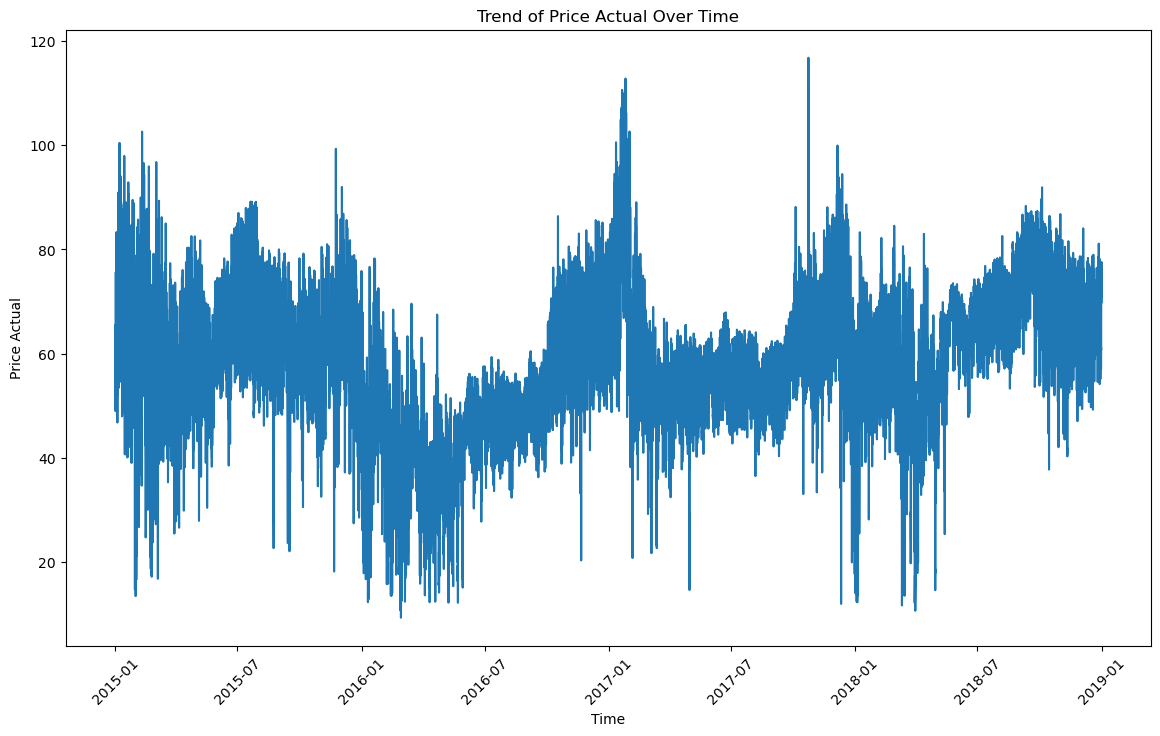

In [44]:
# Trend Analysis
plt.figure(figsize=(14, 8))
sns.lineplot(data=merged_data, x='time', y='price actual')
plt.title('Trend of Price Actual Over Time')
plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.xticks(rotation=45)
plt.show()


Trend Line Plot: Visualizes the trend of price actual over time.

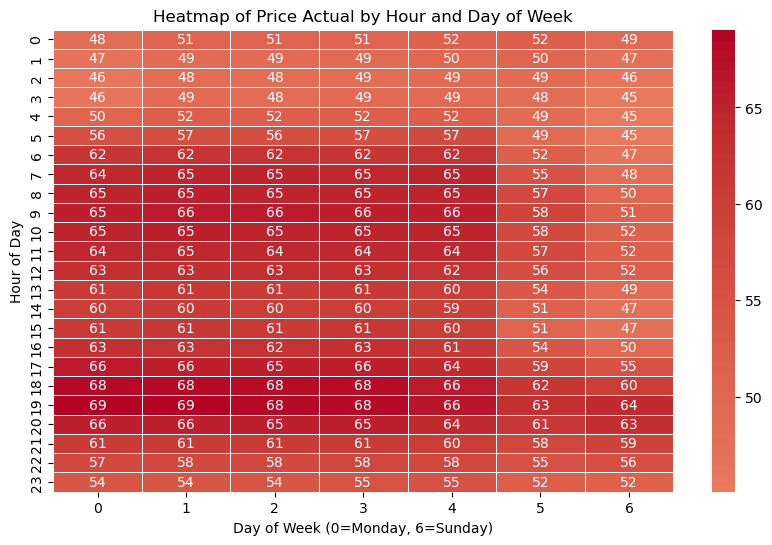

In [45]:
# Heatmap of Hourly Averages
merged_data['hour'] = merged_data['time'].dt.hour
merged_data['day_of_week'] = merged_data['time'].dt.dayofweek
pivot_table = merged_data.pivot_table(values='price actual', index='hour', columns='day_of_week', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Heatmap of Price Actual by Hour and Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Hour of Day')
plt.show()

Displays how price actual changes by hour and day of the week. Useful for identifying daily and weekly patterns.

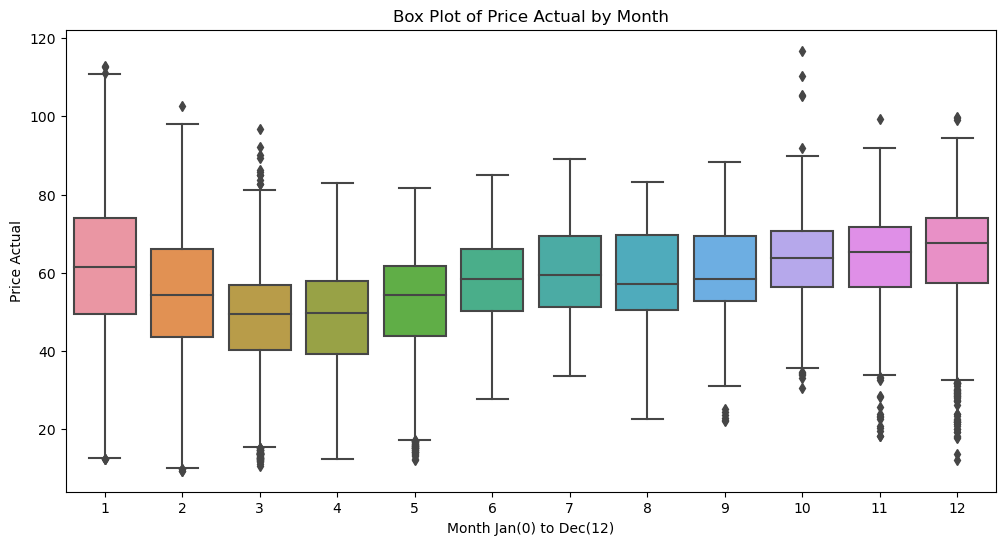

In [46]:
# Box Plot of Prices by Month
merged_data['month'] = merged_data['time'].dt.month
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='month', y='price actual')
plt.title('Box Plot of Price Actual by Month')
plt.xlabel('Month Jan(0) to Dec(12)')
plt.ylabel('Price Actual')
plt.show()


-There is a seasonal pattern with price actual generally being higher during the winter months (December, January, February) and   summer months (June, July, August).
              -This seasonal trend might be driven by increased heating and cooling demands, respectively.
              -Months like April and October show lower prices, likely due to mild weather and reduced energy consumption for heating or cooling.

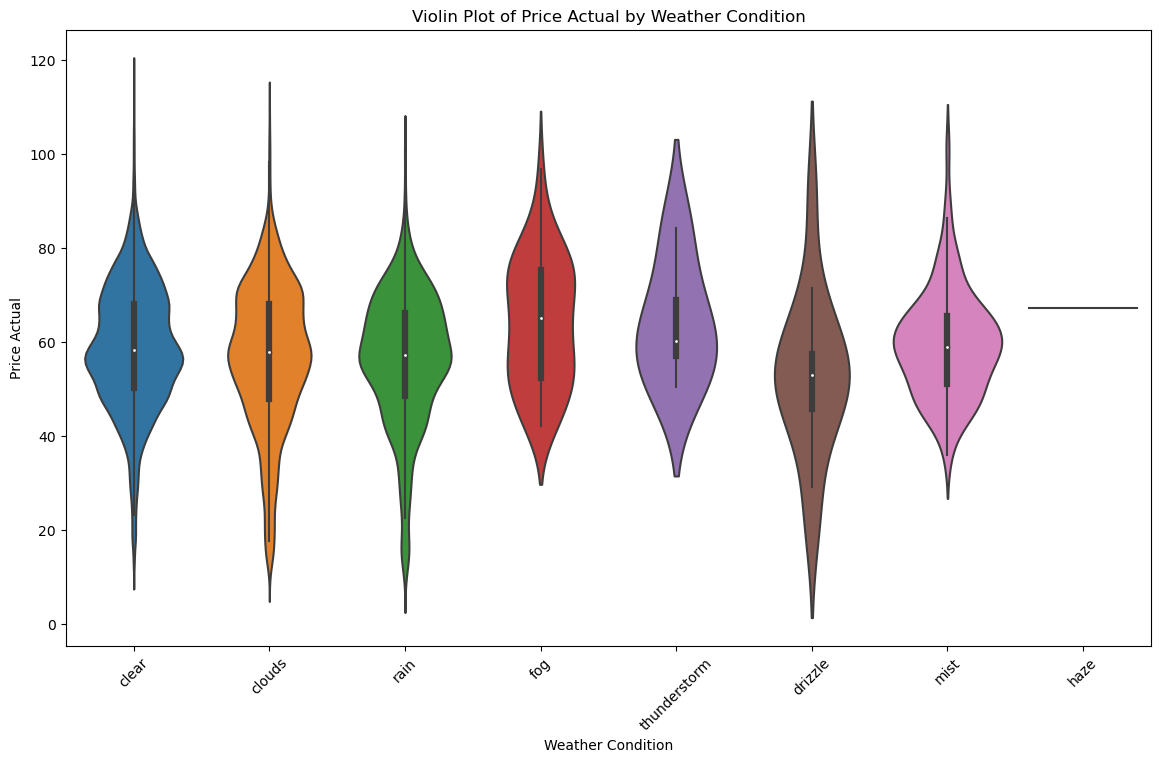

In [47]:
#  Violin Plot of Prices by Weather Conditions
plt.figure(figsize=(14, 8))
sns.violinplot(data=merged_data, x='weather_main', y='price actual')
plt.title('Violin Plot of Price Actual by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Price Actual')
plt.xticks(rotation=45)
plt.show()


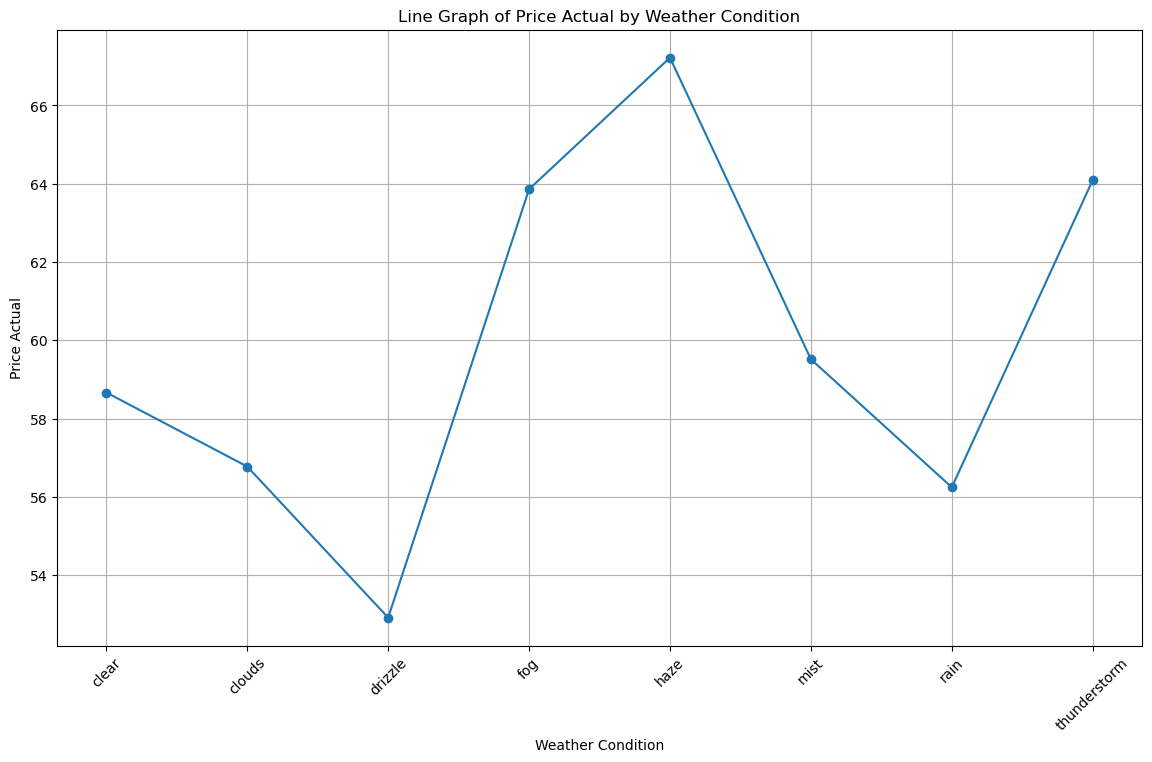

In [48]:
# Group data by weather condition and calculate the mean price for each condition
weather_price_avg = merged_data.groupby('weather_main')['price actual'].mean().reset_index()

# Sort by weather condition for better visualization
weather_price_avg = weather_price_avg.sort_values(by='weather_main')

# Plot the line graph
plt.figure(figsize=(14, 8))
plt.plot(weather_price_avg['weather_main'], weather_price_avg['price actual'], marker='o')
plt.title('Line Graph of Price Actual by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Price Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Violin Plot of Prices by Weather Conditions: Shows the distribution of price actual under different weather conditions.

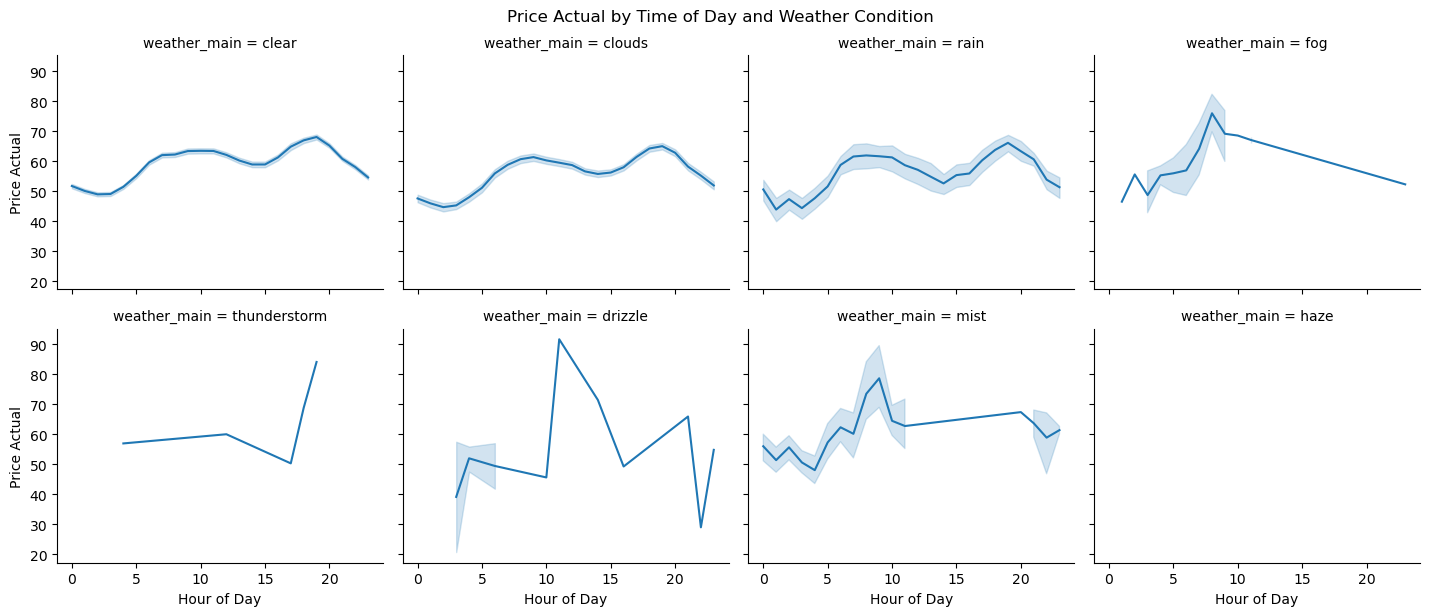

In [49]:
#  Facet Grid for Time of Day and Weather
merged_data['hour'] = merged_data['time'].dt.hour
g = sns.FacetGrid(merged_data, col='weather_main', col_wrap=4, height=3, aspect=1.2)
g.map(sns.lineplot, 'hour', 'price actual')
g.set_axis_labels('Hour of Day', 'Price Actual')
g.add_legend()
plt.suptitle('Price Actual by Time of Day and Weather Condition', y=1.02)
plt.show()

Facet Grid for Time of Day and Weather: Shows how price actual varies throughout the day across different weather conditions.

# Modelling

In [219]:
#To check All Columns in the merged_data
merged_data.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'weather_main', 'weather_description', 'weather_icon',
       'price actual interpolation', 'day_of_week', 'is_weekday', 'hour',
       'hourly_avg_demand', 'peak|off-peak', 'January', 'February', 'March',
      

###### Calculating the correlations of target column with other columns

Number of positive correlations for total load actual: 35
Columns with correlation greater than 0.0 for total load actual:
weather_id                                    0.001192
June                                          0.018526
clouds_all                                    0.019108
rain_1h                                       0.021264
November                                      0.027507
forecast wind onshore day ahead               0.037409
generation wind onshore                       0.039788
February                                      0.050944
January                                       0.073065
generation waste                              0.077163
July                                          0.082244
generation biomass                            0.083438
generation nuclear                            0.085803
generation other                              0.100768
generation hydro run-of-river and poundage    0.118340
generation other renewable                    0.1809

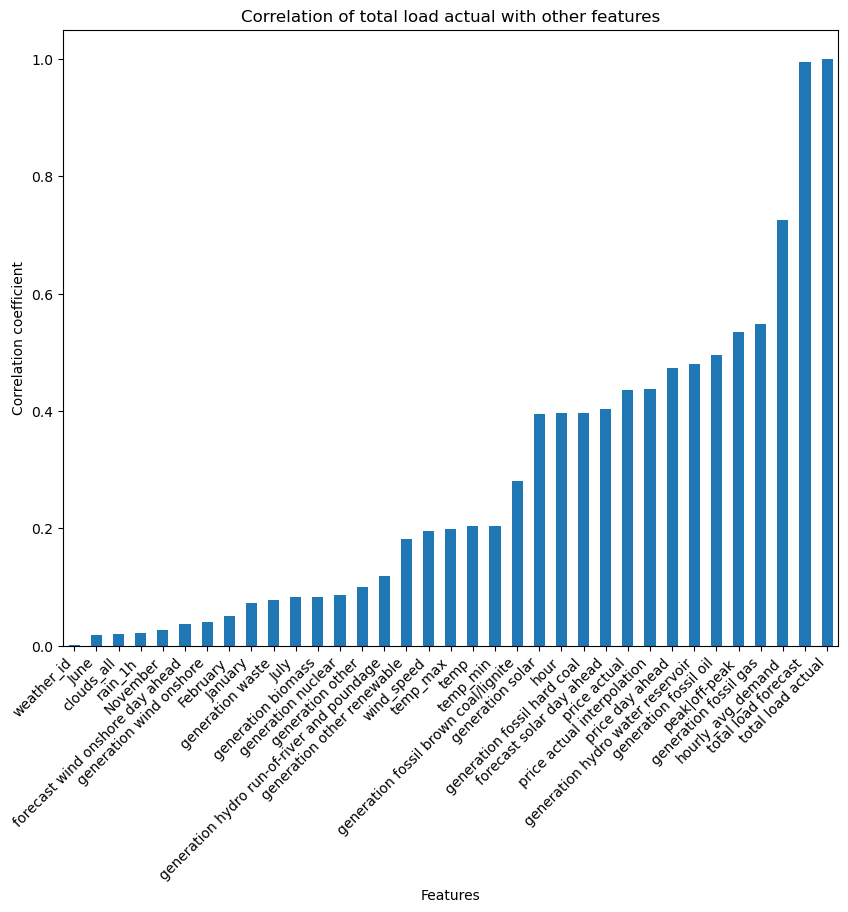

Number of positive correlations for price actual: 34
Columns with correlation greater than 0.0 for price actual:
June                                    0.006940
snow_3h                                 0.014884
August                                  0.024270
day                                     0.026703
July                                    0.053781
temp_max                                0.061787
September                               0.062486
weather_id                              0.063344
generation hydro water reservoir        0.071830
temp                                    0.080356
January                                 0.080405
temp_min                                0.093519
generation solar                        0.098530
generation other                        0.099875
forecast solar day ahead                0.101402
October                                 0.120049
November                                0.125683
generation biomass                      0.142688
Decem

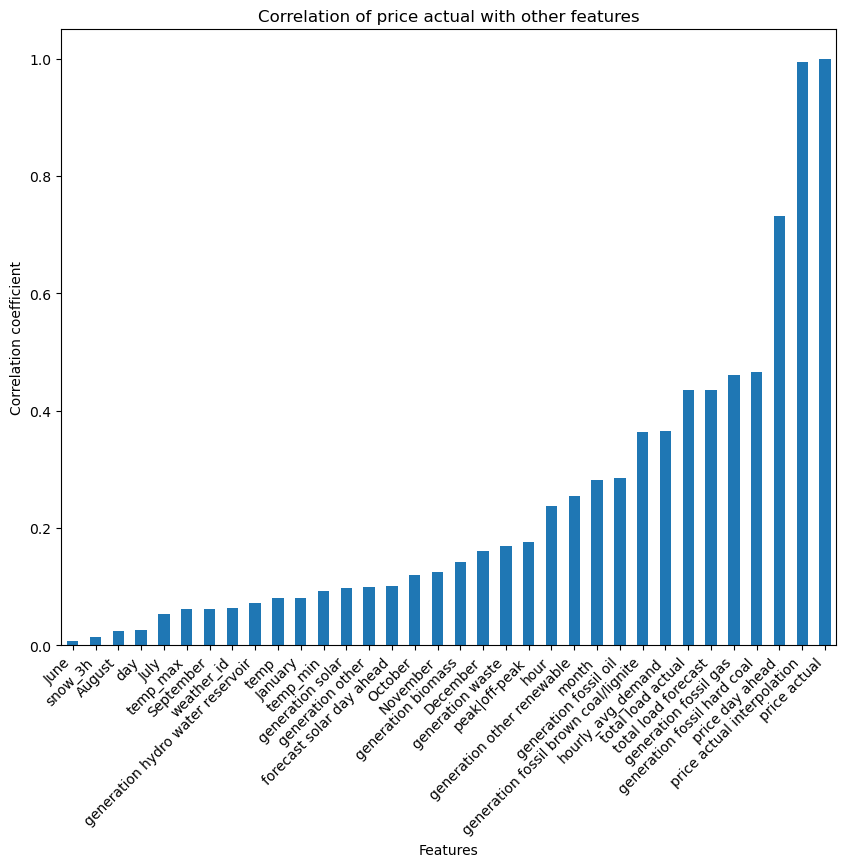

In [188]:
# Define the target columns
target_columns = ['total load actual', 'price actual']

for target_column in target_columns:
    # Calculate correlations of the target column with all other columns
    correlations = merged_data.corr()[target_column].sort_values()

    # Filter out correlations greater than 0.0
    positive_correlations = correlations[correlations > 0.0]

    # Count the number of positive correlations
    b = positive_correlations.count()
    print(f'Number of positive correlations for {target_column}:', b)

    # Print the columns with correlations greater than 0.0
    print(f'Columns with correlation greater than 0.0 for {target_column}:')
    print(positive_correlations)

    # Plot the correlations
    plt.figure(figsize=(10, 8))
    positive_correlations.plot(kind='bar')
    plt.title(f'Correlation of {target_column} with other features')
    plt.xlabel('Features')
    plt.ylabel('Correlation coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.show()

#### Feature Selection & Spliting the data for Load Prediction

In [195]:
# Prepare the data
X_l = merged_data[['hourly_avg_demand', 'generation fossil gas', 'peak|off-peak', 
                 'generation fossil oil', 'generation hydro water reservoir', 'price day ahead', 
                 'price actual interpolation', 'price actual', 'forecast solar day ahead', 'hour', 
                 'generation solar', 'generation fossil brown coal/lignite', 'generation other', 
                 'generation hydro run-of-river and poundage', 'generation other renewable', 
                 'wind_speed', 'temp_max', 'temp','July','January','February','November']]
y_l = merged_data['total load actual']

# Split the data into training and testing sets
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled_l = scaler.fit_transform(X_train_l)
X_test_scaled_l = scaler.transform(X_test_l)

#### Feature Selection & Splitting the data for Price Prediction

In [190]:
#Prepare dependent and independent veariable
X_p = merged_data[[
    'snow_3h', 'temp_max', 'weather_id', 'generation hydro water reservoir', 'temp', 'temp_min',
    'generation solar', 'generation other', 'forecast solar day ahead', 'generation biomass',
    'generation waste', 'peak|off-peak', 'hour', 'generation other renewable', 'month',
    'generation fossil oil', 'generation fossil brown coal/lignite', 'hourly_avg_demand',
    'total load actual', 'generation fossil gas', 'generation fossil hard coal', 'December',
    'October','November','September'
]]
y_p = merged_data['price actual']

# Split the data into training and testing sets
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled_p = scaler.fit_transform(X_train_p)
X_test_scaled_p = scaler.transform(X_test_p)


###### Define Mean Absolute Percentage Error (MAPE) function

In [191]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Linear Regression Model for Load prediction

In [158]:
# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_lr_l = model.predict(X_test_scaled_l)

# Calculate metrics
mse_lr_l = mean_squared_error(y_test_l, y_pred_lr_l)
r2_lr_l = r2_score(y_test_l, y_pred_lr_l)
mae_lr_l = mean_absolute_error(y_test_l, y_pred_lr_l)
rmse_lr_l = np.sqrt(mse_lr_l)
mape_lr_l = mean_absolute_percentage_error(y_test_l, y_pred_lr_l)

n = X_test_l.shape[0]
p = X_test_l.shape[1]
adjusted_r2_lr_l = 1 - ((1 - r2_lr_l) * (n - 1) / (n - p - 1))

print(f'Mean Squared Error (MSE): {mse_lr_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lr_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lr_l:.2f}')
print(f'R-squared (R^2): {r2_lr_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lr_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lr_l:.2f}%')

Mean Squared Error (MSE): 2544405.34
Root Mean Squared Error (RMSE): 1595.12
Mean Absolute Error (MAE): 1256.93
R-squared (R^2): 0.88
Adjusted R-squared: 0.88
Mean Absolute Percentage Error (MAPE): 4.50%


### Linear Regression Model for Price Prediction

In [159]:
# Train the model
model = LinearRegression()
model.fit(X_train_scaled_p, y_train_p)

# Make predictions
y_pred_lr_p = model.predict(X_test_scaled_p)

# Calculate metrics
mse_lr_p = mean_squared_error(y_test_p, y_pred_lr_p)
r2_lr_p = r2_score(y_test_p, y_pred_lr_p)
mae_lr_p = mean_absolute_error(y_test_p, y_pred_lr_p)
rmse_lr_p = np.sqrt(mse_lr_p)
# Calculate adjusted R-squared
n = X_test_p.shape[0]
p = X_test_p.shape[1]
adjusted_r2_lr_p = 1 - ((1 - r2_lr_p) * (n - 1) / (n - p - 1))



mape_lr_p = mean_absolute_percentage_error(y_test_p, y_pred_lr_p)

# Print the results
print(f'Mean Squared Error (MSE): {mse_lr_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lr_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lr_p:.2f}')
print(f'R-squared (R^2): {r2_lr_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lr_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lr_p:.2f}%')

Mean Squared Error (MSE): 111.84
Root Mean Squared Error (RMSE): 10.58
Mean Absolute Error (MAE): 8.00
R-squared (R^2): 0.45
Adjusted R-squared: 0.45
Mean Absolute Percentage Error (MAPE): 16.92%


### Random Forest Model for Load Prediction

In [196]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_rf_l = rf_model.predict(X_test_scaled_l)

# Calculate metrics
mse_rf_l = mean_squared_error(y_test_l, y_pred_rf_l)
r2_rf_l = r2_score(y_test_l, y_pred_rf_l)
mae_rf_l = mean_absolute_error(y_test_l, y_pred_rf_l)
rmse_rf_l = np.sqrt(mse_rf_l)
mape_rf_l = mean_absolute_percentage_error(y_test_l, y_pred_rf_l)

# Calculate adjusted R-squared
n = X_test_l.shape[0]
p = X_test_l.shape[1]
adjusted_r2_rf_l = 1 - ((1 - r2_rf_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nRandom Forest Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_l:.2f}')
print(f'R-squared (R²): {r2_rf_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_l:.2f}%')


Random Forest Model for `total load actual`:
Mean Squared Error (MSE): 1043239.76
Root Mean Squared Error (RMSE): 1021.39
Mean Absolute Error (MAE): 762.39
R-squared (R²): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 2.72%


### Random Forest Model for Price Prediction

In [198]:
# Initialize the model
rf_model_p = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model_p.fit(X_train_scaled_p.reshape(X_train_scaled_p.shape[0], -1), y_train_p)

# Make predictions
y_pred_rf_p = rf_model_p.predict(X_test_scaled_p.reshape(X_test_scaled_p.shape[0], -1))

# Calculate metrics
mse_rf_p = mean_squared_error(y_test_p, y_pred_rf_p)
rmse_rf_p = np.sqrt(mse_rf_p)
mae_rf_p = mean_absolute_error(y_test_p, y_pred_rf_p)
r2_rf_p = r2_score(y_test_p, y_pred_rf_p)
mape_rf_p = mean_absolute_percentage_error(y_test_p, y_pred_rf_p)

# Calculate adjusted R-squared
n = X_test_scaled_p.shape[0]
p = X_test_scaled_p.shape[1]  # use the number of features
adjusted_r2_rf_p = 1 - ((1 - r2_rf_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nRandom Forest Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_p:.2f}')
print(f'R-squared (R²): {r2_rf_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_p:.2f}%')


Random Forest Model for `price actual`:
Mean Squared Error (MSE): 22.96
Root Mean Squared Error (RMSE): 4.79
Mean Absolute Error (MAE): 3.27
R-squared (R²): 0.89
Adjusted R-squared: 0.89
Mean Absolute Percentage Error (MAPE): 6.66%


### Gradient Boosting Model for Load Prediction

In [162]:
# Initialize the Gradient Boosting model
gb_model_l = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
gb_model.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_gb_l = gb_model.predict(X_test_scaled_l)

# Calculate metrics
mse_gb_l = mean_squared_error(y_test_l, y_pred_gb_l)
rmse_gb_l = np.sqrt(mse_gb_l)
mae_gb_l = mean_absolute_error(y_test_l, y_pred_gb_l)
r2_gb_l = r2_score(y_test_l, y_pred_gb_l)
mape_gb_l = mean_absolute_percentage_error(y_test_l, y_pred_gb_l)

# Calculate adjusted R-squared
n = X_test_l.shape[0]
p = X_test_l.shape[1]
adjusted_r2_gb_l = 1 - ((1 - r2_gb_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nGradient Boosting Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_gb_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_gb_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_gb_l:.2f}')
print(f'R-squared (R²): {r2_gb_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_gb_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_gb_l:.2f}%')



Gradient Boosting Model for `total load actual`:
Mean Squared Error (MSE): 1055079.44
Root Mean Squared Error (RMSE): 1027.17
Mean Absolute Error (MAE): 784.10
R-squared (R²): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 2.77%


### Gradient Boosting Model for Price Prediction

In [163]:
# Initialize the Gradient Boosting model
gb_model_p = GradientBoostingRegressor(n_estimators=200, learning_rate=0.5, max_depth=5, random_state=42)

# Train the model
gb_model.fit(X_train_scaled_p, y_train_p)

# Make predictions
y_pred_gb_p = gb_model.predict(X_test_scaled_p)

# Calculate metrics
mse_gb_p = mean_squared_error(y_test_p, y_pred_gb_p)
rmse_gb_p = np.sqrt(mse_gb_p)
mae_gb_p = mean_absolute_error(y_test_p, y_pred_gb_p)
r2_gb_p = r2_score(y_test_p, y_pred_gb_p)
mape_gb_p = mean_absolute_percentage_error(y_test_p, y_pred_gb_p)

# Calculate adjusted R-squared
n = X_test_p.shape[0]
p = X_test_p.shape[1]
adjusted_r2_gb_p = 1 - ((1 - r2_gb_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nGradient Boosting Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_gb_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_gb_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_gb_p:.2f}')
print(f'R-squared (R²): {r2_gb_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_gb_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_gb_p:.2f}%')



Gradient Boosting Model for `price actual`:
Mean Squared Error (MSE): 31.15
Root Mean Squared Error (RMSE): 5.58
Mean Absolute Error (MAE): 4.19
R-squared (R²): 0.85
Adjusted R-squared: 0.85
Mean Absolute Percentage Error (MAPE): 8.30%


###    Random Forest Model for Load Prediction with Parameter Tunning

In [165]:
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Train the model with RandomizedSearchCV
random_search.fit(X_train_scaled_l, y_train_l)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Train the final model with the best parameters
best_rf_model_tun_l = random_search.best_estimator_
best_rf_model_tun_l.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_rf_tun_l = best_rf_model_tun_l.predict(X_test_scaled_l)

# Calculate metrics
mse_rf_tun_l = mean_squared_error(y_test_l, y_pred_rf_tun_l)
rmse_rf_tun_l = np.sqrt(mse_rf_tun_l)
mae_rf_tun_l = mean_absolute_error(y_test_l, y_pred_rf_tun_l)
r2_rf_tun_l = r2_score(y_test_l, y_pred_rf_tun_l)
mape_rf_tun_l = mean_absolute_percentage_error(y_test_l, y_pred_rf_tun_l)
# Calculate adjusted R-squared
n = X_test_l.shape[0]
p = X_test_l.shape[1]
adjusted_r2_rf_tun_l = 1 - ((1 - r2_rf_tun_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Random Forest Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_tun_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_tun_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_tun_l:.2f}')
print(f'R-squared (R²): {r2_rf_tun_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_tun_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_tun_l:.2f}%')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 90}

Tuned Random Forest Model for `total load actual`:
Mean Squared Error (MSE): 1048847.26
Root Mean Squared Error (RMSE): 1024.13
Mean Absolute Error (MAE): 765.82
R-squared (R²): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 2.74%


### Random Forest Model Price Prediction with Parameter Tunning

In [203]:
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200,500,1000],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Train the model with RandomizedSearchCV
random_search.fit(X_train_scaled_p, y_train_p)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Train the final model with the best parameters
best_rf_model_tun_p = random_search.best_estimator_
best_rf_model_tun_p.fit(X_train_scaled_p, y_train_p)

# Make predictions
y_pred_rf_tun_p = best_rf_model_tun_p.predict(X_test_scaled_p)

# Calculate metrics
mse_rf_tun_p = mean_squared_error(y_test_p, y_pred_rf_tun_p)
rmse_rf_tun_p = np.sqrt(mse_rf_tun_p)
mae_rf_tun_p = mean_absolute_error(y_test_p, y_pred_rf_tun_p)
r2_rf_tun_p = r2_score(y_test_p, y_pred_rf_tun_p)
mape_rf_tun_p = mean_absolute_percentage_error(y_test_p, y_pred_rf_tun_p)

# Calculate adjusted R-squared
n = X_test_p.shape[0]
p = X_test_p.shape[1]
adjusted_r2_rf_tun_p = 1 - ((1 - r2_rf_tun_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Random Forest Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_rf_tun_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_tun_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf_tun_p:.2f}')
print(f'R-squared (R²): {r2_rf_tun_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_rf_tun_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf_tun_p:.2f}%')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None}

Tuned Random Forest Model for `price actual`:
Mean Squared Error (MSE): 23.07
Root Mean Squared Error (RMSE): 4.80
Mean Absolute Error (MAE): 3.28
R-squared (R²): 0.89
Adjusted R-squared: 0.89
Mean Absolute Percentage Error (MAPE): 6.70%


### Gradient Boosting Model for Load Prediction with Parameter tunning

In [170]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Gradient Boosting model
model_gb_tuned = GradientBoostingRegressor(random_state=42)

# Set up the GridSearchCV
grid_search_gb = GridSearchCV(estimator=model_gb_tuned, param_grid=param_grid_gb, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=2)

# Fit the GridSearchCV
grid_search_gb.fit(X_train_scaled_l, y_train_l)

# Print the best parameters and score
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"Best Score: {grid_search_gb.best_score_}")

# Train the model with the best parameters
best_gb_model_tun_l = grid_search_gb.best_estimator_
best_gb_model_tun_l.fit(X_train_scaled_l, y_train_l)

# Make predictions
y_pred_best_gb_tun_l = best_gb_model_tun_l.predict(X_test_scaled_l)

# Calculate metrics
mse_best_gb_tun_l = mean_squared_error(y_test_l, y_pred_best_gb_tun_l)
rmse_best_gb_tun_l = np.sqrt(mse_best_gb_tun_l)
mae_best_gb_tun_l = mean_absolute_error(y_test_l, y_pred_best_gb_tun_l)
r2_best_gb_tun_l = r2_score(y_test_l, y_pred_best_gb_tun_l)
mape_best_gb_tun_l = mean_absolute_percentage_error(y_test_l, y_pred_best_gb_tun_l)

# Calculate adjusted R-squared
n = X_test_scaled_l.shape[0]
p = X_test_scaled_l.shape[1]
adjusted_r2_best_gb_tun_l = 1 - ((1 - r2_best_gb_tun_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Gradient Boosting Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_best_gb_tun_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_best_gb_tun_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_best_gb_tun_l:.2f}')
print(f'R-squared (R²): {r2_best_gb_tun_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_best_gb_tun_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_best_gb_tun_l:.2f}%')

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.02582837523166789

Tuned Gradient Boosting Model for `total load actual`:
Mean Squared Error (MSE): 827652.34
Root Mean Squared Error (RMSE): 909.75
Mean Absolute Error (MAE): 687.65
R-squared (R²): 0.96
Adjusted R-squared: 0.96
Mean Absolute Percentage Error (MAPE): 2.44%


### Gradient Boosting Model for Price Prediction with Parameter tunning

In [171]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Gradient Boosting model
model_gb_tuned = GradientBoostingRegressor(random_state=42)

# Set up the GridSearchCV
grid_search_gb = GridSearchCV(estimator=model_gb_tuned, param_grid=param_grid_gb, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=2)

# Fit the GridSearchCV
grid_search_gb.fit(X_train_scaled_p, y_train_p)

# Print the best parameters and score
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"Best Score: {grid_search_gb.best_score_}")

# Train the model with the best parameters
best_gb_model_tun_p = grid_search_gb.best_estimator_
best_gb_model_tun_p.fit(X_train_scaled_p, y_train_p)

# Make predictions
y_pred_best_gb_tun_p = best_gb_model_tun_p.predict(X_test_scaled_p)

# Calculate metrics
mse_best_gb_tun_p = mean_squared_error(y_test_p, y_pred_best_gb_tun_p)
rmse_best_gb_tun_p = np.sqrt(mse_best_gb_tun_p)
mae_best_gb_tun_p = mean_absolute_error(y_test_p, y_pred_best_gb_tun_p)
r2_best_gb_tun_p = r2_score(y_test_p, y_pred_best_gb_tun_p)
mape_best_gb_tun_p = mean_absolute_percentage_error(y_test_p, y_pred_best_gb_tun_p)

# Calculate adjusted R-squared
n = X_test_p.shape[0]
p = X_test_p.shape[1]
adjusted_r2_best_gb_tun_p = 1 - ((1 - r2_best_gb_tun_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nTuned Gradient Boosting Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_best_gb_tun_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_best_gb_tun_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_best_gb_tun_p:.2f}')
print(f'R-squared (R²): {r2_best_gb_tun_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_best_gb_tun_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_best_gb_tun_p:.2f}%')

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.07410892440733502

Tuned Gradient Boosting Model for `price actual`:
Mean Squared Error (MSE): 21.93
Root Mean Squared Error (RMSE): 4.68
Mean Absolute Error (MAE): 3.48
R-squared (R²): 0.89
Adjusted R-squared: 0.89
Mean Absolute Percentage Error (MAPE): 6.95%


# LONG SHORT TERM MEMORY(LSTM) MODEL

In [172]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



### LSTM Model for Load Predicton

In [181]:
# Check the shapes 
print(f"X_train_scaled_l shape: {X_train_scaled_l.shape}")
print(f"X_test_scaled_l shape: {X_test_scaled_l.shape}")

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_scaled_l.shape[1], X_train_scaled_l.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled_l, y_train_l, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_lstm_l = model.predict(X_test_scaled_l).flatten()

# Calculate metrics
mse_lstm_l = mean_squared_error(y_test_l, y_pred_lstm_l)
rmse_lstm_l = np.sqrt(mse_lstm_l)
mae_lstm_l = mean_absolute_error(y_test_l, y_pred_lstm_l)
r2_lstm_l = r2_score(y_test_l, y_pred_lstm_l)
mape_lstm_l = mean_absolute_percentage_error(y_test_l, y_pred_lstm_l)

# Calculate adjusted R-squared
n = X_test_scaled_l.shape[0]
p = X_test_scaled_l.shape[2]
adjusted_r2_lstm_l = 1 - ((1 - r2_lstm_l) * (n - 1) / (n - p - 1))

# Print the results
print("\nLSTM Model for `total load actual`:")
print(f'Mean Squared Error (MSE): {mse_lstm_l:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_l:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lstm_l:.2f}')
print(f'R-squared (R²): {r2_lstm_l:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lstm_l:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lstm_l:.2f}%')

X_train_scaled_l shape: (28051, 1, 22)
X_test_scaled_l shape: (7013, 1, 22)
Epoch 1/50


C:\Users\deepk\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 774991488.0000 - val_loss: 193856336.0000
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 146520416.0000 - val_loss: 62809704.0000
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 62534332.0000 - val_loss: 29010282.0000
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36673224.0000 - val_loss: 17207678.0000
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27752056.0000 - val_loss: 11615660.0000
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 22529696.0000 - val_loss: 8571464.0000
Epoch 7/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 19550150.0000 - val_loss: 6772432.0000
Epoch 8/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17507806.0000 - val_loss: 5387715.5000
Epoch 9/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16204902.0000 - val_loss: 4687506.5000
Epoch 10/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15372797.0000 - val_loss: 3922035.2500
Epoch 11/50


### LSTM Model for Price Prediction

In [182]:
# Reshape the data to fit the LSTM model (samples, timesteps, features)
timesteps = 1  # Adjust this according to your specific use case
X_train_scaled_p = X_train_scaled_p.reshape((X_train_scaled_p.shape[0], timesteps, X_train_scaled_p.shape[1]))
X_test_scaled_p = X_test_scaled_p.reshape((X_test_scaled_p.shape[0], timesteps, X_test_scaled_p.shape[1]))

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(timesteps, X_train_scaled_p.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled_p, y_train_p, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions
y_pred_lstm_p = model.predict(X_test_scaled_p).flatten()

# Calculate metrics
mse_lstm_p = mean_squared_error(y_test_p, y_pred_lstm_p)
rmse_lstm_p = np.sqrt(mse_lstm_p)
mae_lstm_p = mean_absolute_error(y_test_p, y_pred_lstm_p)
r2_lstm_p = r2_score(y_test_p, y_pred_lstm_p)
mape_lstm_p = np.mean(np.abs((y_test_p - y_pred_lstm_p) / y_test_p)) * 100

# Calculate adjusted R-squared
n = X_test_scaled_p.shape[0]
p = X_test_scaled_p.shape[2]
adjusted_r2_lstm_p = 1 - ((1 - r2_lstm_p) * (n - 1) / (n - p - 1))

# Print the results
print("\nLSTM Model for `price actual`:")
print(f'Mean Squared Error (MSE): {mse_lstm_p:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_p:.2f}')
print(f'Mean Absolute Error (MAE): {mae_lstm_p:.2f}')
print(f'R-squared (R²): {r2_lstm_p:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_lstm_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_lstm_p:.2f}%')

Epoch 1/200


C:\Users\deepk\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


702/702 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1572.9301 - val_loss: 120.4102
Epoch 2/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 167.8869 - val_loss: 87.5226
Epoch 3/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 139.3423 - val_loss: 79.5222
Epoch 4/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 131.2040 - val_loss: 74.9755
Epoch 5/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 126.8847 - val_loss: 72.4166
Epoch 6/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 120.6918 - val_loss: 69.2476
Epoch 7/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 118.5622 - val_loss: 72.9165
Epoch 8/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 113.8594 - val_loss: 66.1069
Epoch 9/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 114.4999 - val_loss: 65.8279
Epoch 10/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 111.1611 - val_loss: 63.0136
Epoch 11/200
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 109.1049 - val_loss: 61.1852
Epoch 12/200
702/7

#### Comparision Table among all the Models

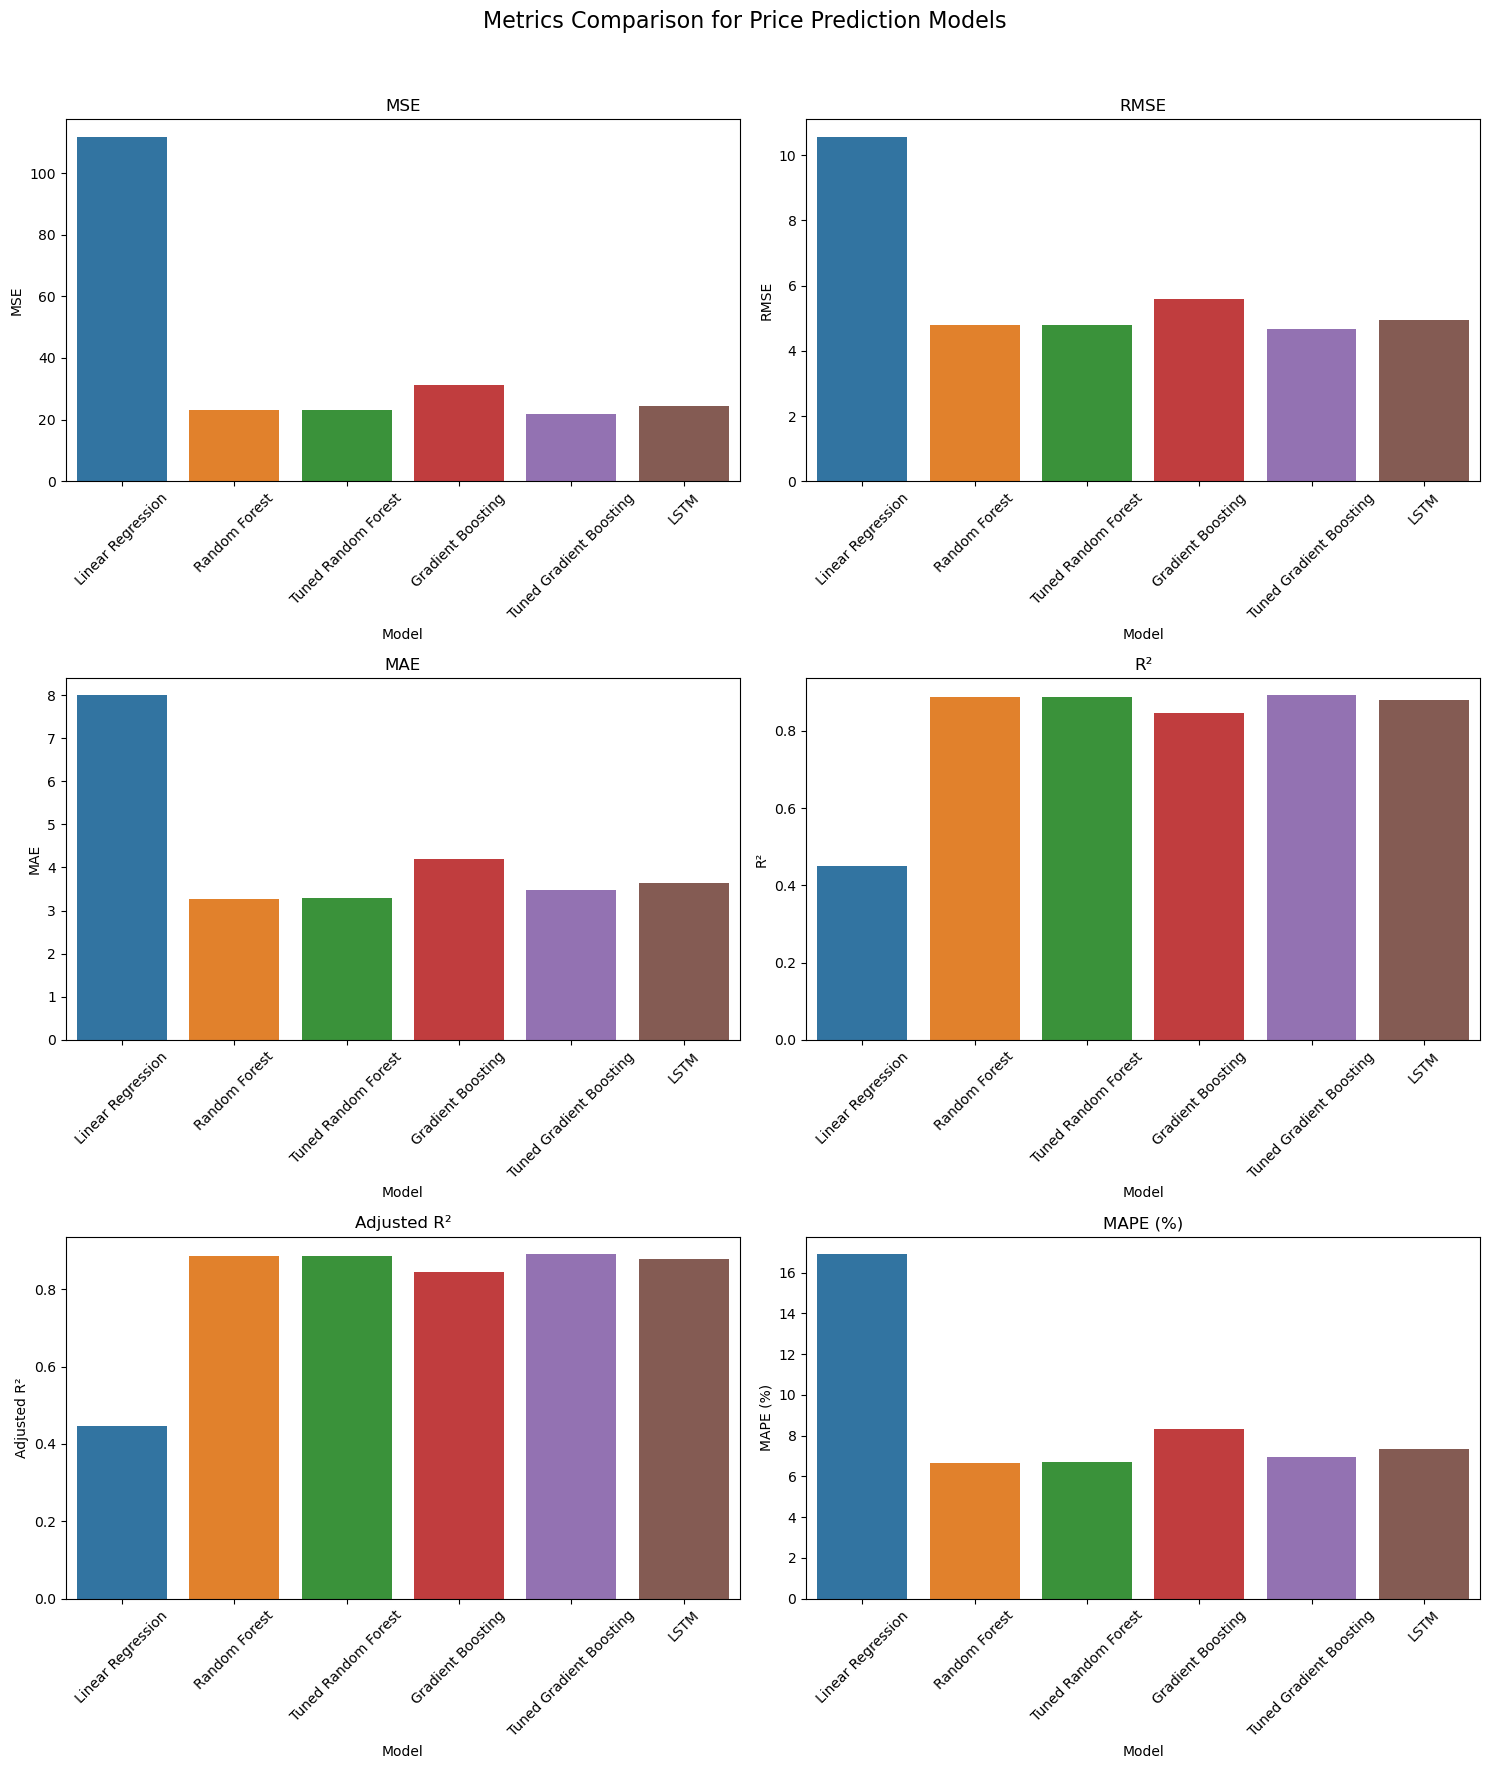

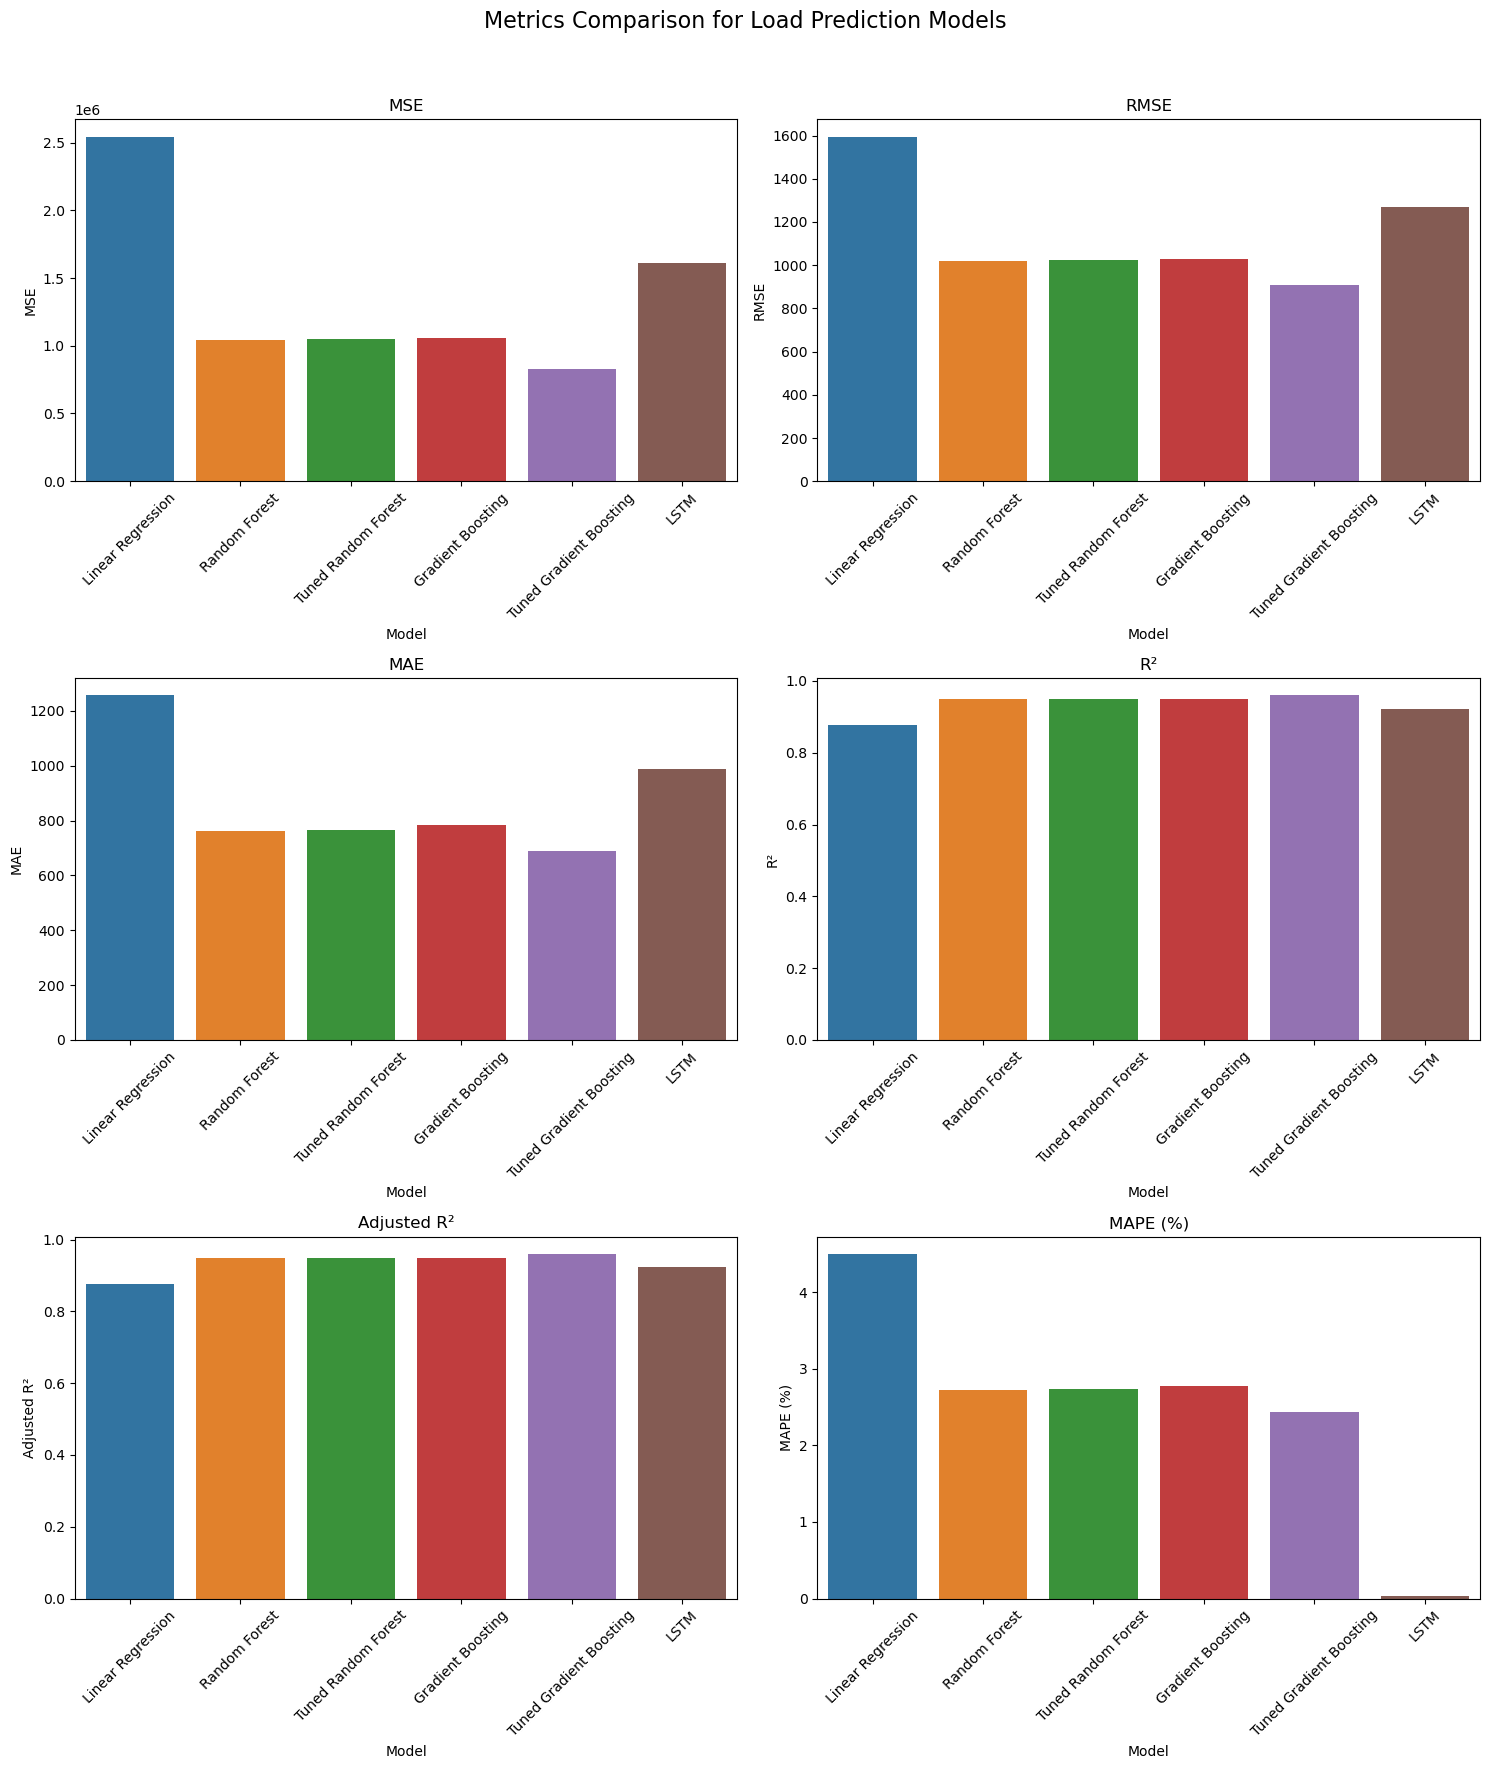

In [231]:
from IPython.display import display

# Round function for MAPE values to two decimal places
def round_mape(mape):
    return round(mape, 2)

# Define the metrics for price prediction
price_metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Tuned Random Forest', 'Gradient Boosting', 'Tuned Gradient Boosting', 'LSTM'],
    'MSE': [mse_lr_p, mse_rf_p, mse_rf_tun_p, mse_gb_p, mse_best_gb_tun_p, mse_lstm_p],
    'RMSE': [rmse_lr_p, rmse_rf_p, rmse_rf_tun_p, rmse_gb_p, rmse_best_gb_tun_p, rmse_lstm_p],
    'MAE': [mae_lr_p, mae_rf_p, mae_rf_tun_p, mae_gb_p, mae_best_gb_tun_p, mae_lstm_p],
    'R²': [r2_lr_p, r2_rf_p, r2_rf_tun_p, r2_gb_p, r2_best_gb_tun_p, r2_lstm_p],
    'Adjusted R²': [adjusted_r2_lr_p, adjusted_r2_rf_p, adjusted_r2_rf_tun_p, adjusted_r2_gb_p, adjusted_r2_best_gb_tun_p, adjusted_r2_lstm_p],
    'MAPE (%)': [mape_lr_p, mape_rf_p, mape_rf_tun_p, mape_gb_p, mape_best_gb_tun_p, mape_lstm_p]
}

# Define the metrics for total load actual prediction
load_metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Tuned Random Forest', 'Gradient Boosting', 'Tuned Gradient Boosting', 'LSTM'],
    'MSE': [mse_lr_l, mse_rf_l, mse_rf_tun_l, mse_gb_l, mse_best_gb_tun_l, mse_lstm_l],
    'RMSE': [rmse_lr_l, rmse_rf_l, rmse_rf_tun_l, rmse_gb_l, rmse_best_gb_tun_l, rmse_lstm_l],
    'MAE': [mae_lr_l, mae_rf_l, mae_rf_tun_l, mae_gb_l, mae_best_gb_tun_l, mae_lstm_l],
    'R²': [r2_lr_l, r2_rf_l, r2_rf_tun_l, r2_gb_l, r2_best_gb_tun_l, r2_lstm_l],
    'Adjusted R²': [adjusted_r2_lr_l, adjusted_r2_rf_l, adjusted_r2_rf_tun_l, adjusted_r2_gb_l, adjusted_r2_best_gb_tun_l, adjusted_r2_lstm_l],
    'MAPE (%)': [mape_lr_l, mape_rf_l, mape_rf_tun_l, mape_gb_l, mape_best_gb_tun_l, mape_lstm_l]
}

# Create dataframes
price_df = pd.DataFrame(price_metrics)
load_df = pd.DataFrame(load_metrics)

# Format MAPE values to two decimal places
price_df['MAPE (%)'] = price_df['MAPE (%)'].apply(round_mape)
load_df['MAPE (%)'] = load_df['MAPE (%)'].apply(round_mape)

# Plotting the metrics
def plot_metrics(df, title):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle(title, fontsize=16)
    metrics = ['MSE', 'RMSE', 'MAE', 'R²', 'Adjusted R²', 'MAPE (%)']
    
    for metric, ax in zip(metrics, axes.flatten()):
        sns.barplot(x='Model', y=metric, data=df, ax=ax)
        ax.set_title(metric)
        ax.set_xlabel('Model')
        ax.set_ylabel(metric)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot metrics for price prediction
plot_metrics(price_df, 'Metrics Comparison for Price Prediction Models')

# Plot metrics for load prediction
plot_metrics(load_df, 'Metrics Comparison for Load Prediction Models')

In [232]:
# Display the tables
print("\nComparison Table for Price Prediction:")
display(price_df)

print("\nComparison Table for Load Prediction:")
display(load_df)


Comparison Table for Price Prediction:


,Model,MSE,RMSE,MAE,R²,Adjusted R²,MAPE (%)
0,Linear Regression,111.836927,10.575298,7.996058,0.449263,0.447293,16.92
1,Random Forest,22.963171,4.791990,3.273069,0.886919,0.886514,6.66
2,Tuned Random Forest,23.065845,4.802691,3.284481,0.886413,0.886007,6.70
3,Gradient Boosting,31.150382,5.581253,4.188399,0.846601,0.846052,8.30
4,Tuned Gradient Boosting,21.925169,4.682432,3.476693,0.892030,0.891644,6.95
5,LSTM,24.562742,4.956081,3.639290,0.879042,0.878609,7.35



Comparison Table for Load Prediction:


,Model,MSE,RMSE,MAE,R²,Adjusted R²,MAPE (%)
0,Linear Regression,2.544405e+06,1595.119224,1256.933887,0.878008,0.877624,4.50
1,Random Forest,1.043240e+06,1021.391089,762.391306,0.949982,0.949824,2.72
2,Tuned Random Forest,1.048847e+06,1024.132440,765.815601,0.949713,0.949555,2.74
3,Gradient Boosting,1.055079e+06,1027.170598,784.099797,0.949414,0.949255,2.77
4,Tuned Gradient Boosting,8.276523e+05,909.754000,687.650279,0.960318,0.960193,2.44
5,LSTM,1.610046e+06,1268.875715,988.124378,0.922806,0.922563,0.03


# Final Report

##### For Price Prediction Model
consider using either the Random Forest model or the Tuned Gradient Boosting model due to their balanced performance in terms of MAPE and R².

##### For Load Prediction Model
the LSTM model is strongly recommended for its exceptionally low MAPE and high R² values.

##### Monthly Actual vs Predicted Electricity Demand

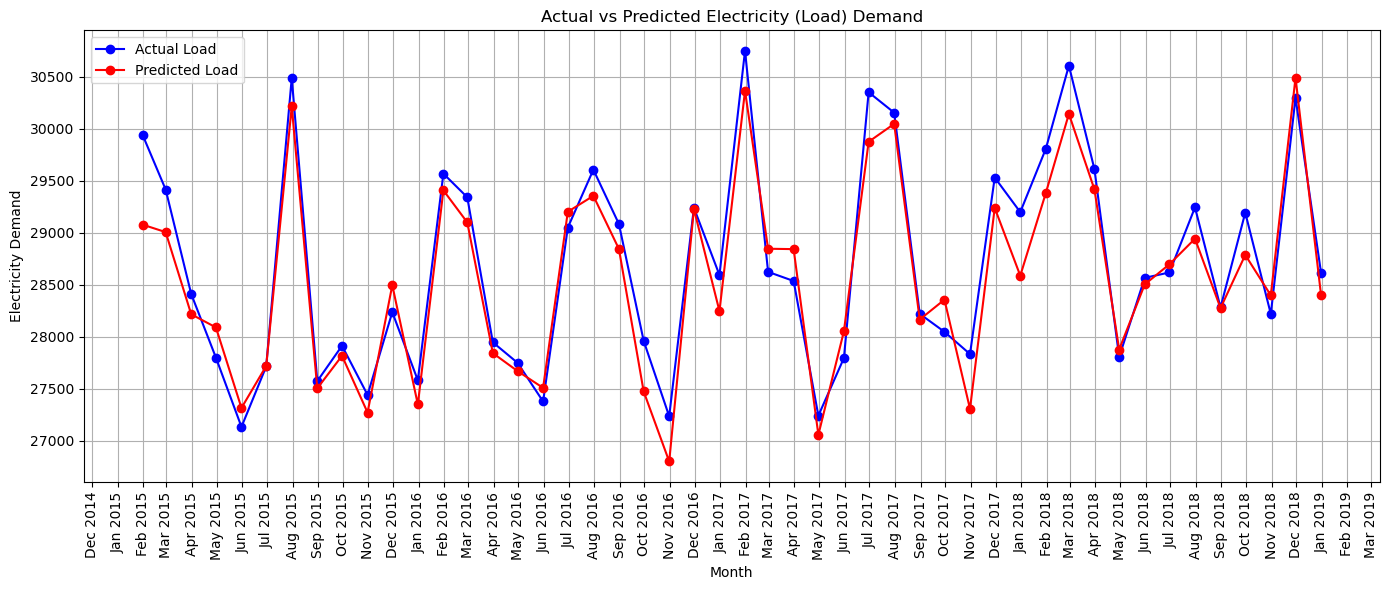

In [224]:
import matplotlib.dates as mdates
# Align y_test_l and y_pred_lstm_l with the test set indices
test_indices = X_test_l.index

# Get the corresponding dates for the test set
test_dates = merged_data.loc[test_indices, 'time']

# Convert test_dates to datetime if not already
test_dates = pd.to_datetime(test_dates)

# Create a DataFrame with the dates, actual, and predicted values
results_df = pd.DataFrame({'Date': test_dates, 'Actual Load': y_test_l, 'Predicted Load': y_pred_lstm_l})

# Set Date as the index
results_df.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results = results_df.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results.index, monthly_results['Actual Load'], label='Actual Load', color='blue', marker='o')
plt.plot(monthly_results.index, monthly_results['Predicted Load'], label='Predicted Load', color='red', marker='o')
plt.title('Actual vs Predicted Electricity (Load) Demand')
plt.xlabel('Month')
plt.ylabel('Electricity Demand')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Monthly Actual vs Predicted Electricity Price

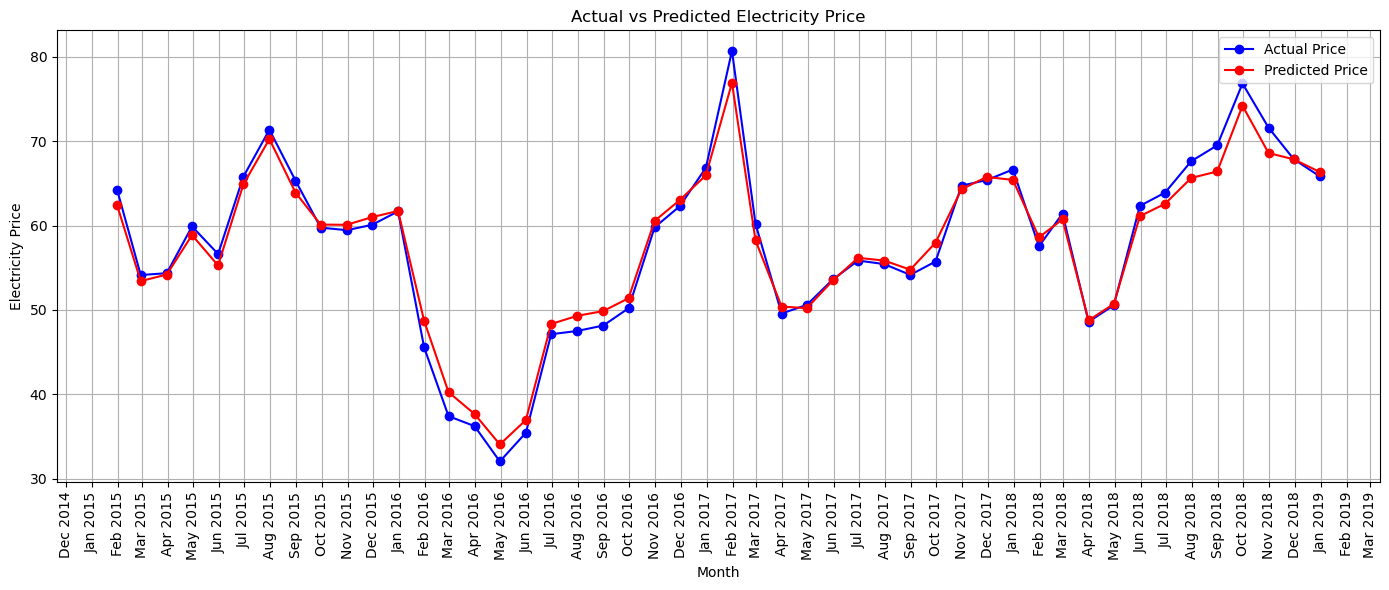

In [225]:
# Ensure y_test_p and y_pred_rf_p are aligned with the test set indices
test_indices_p = X_test_p.index

# Get the corresponding dates for the test set
test_dates_p = merged_data.loc[test_indices_p, 'time']

# Convert test_dates to datetime if not already
test_dates_p = pd.to_datetime(test_dates_p)

# Create a DataFrame with the dates, actual, and predicted values
results_df_p = pd.DataFrame({'Date': test_dates_p, 'Actual Price': y_test_p, 'Predicted Price': y_pred_rf_p})

# Set Date as the index
results_df_p.set_index('Date', inplace=True)

# Group by month and calculate the mean for each month
monthly_results_p = results_df_p.resample('M').mean()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(monthly_results_p.index, monthly_results_p['Actual Price'], label='Actual Price', color='blue', marker='o')
plt.plot(monthly_results_p.index, monthly_results_p['Predicted Price'], label='Predicted Price', color='red', marker='o')
plt.title('Actual vs Predicted Electricity Price')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()